<a href="https://colab.research.google.com/github/yaeunjess/ML-basic/blob/main/ML_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1주차 과제

## Setup

In [ ]:
import numpy as np
import keras
from keras import layers

## Prepare the data

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Build the model

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

## Train the model

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

## Evaluate the trained model

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

## tensor->torch 코드 변환

### 최종 코드

In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from PIL import Image

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=5,
                stride=1), # 컨볼루션 레이어: 입력 채널 1, 출력 채널 32, 커널 크기 5x5, 스트라이드 1
            nn.LeakyReLU(), # LeakyReLU 활성화 함수
            nn.BatchNorm2d(32), # 배치 정규화
            nn.MaxPool2d(kernel_size=2), # 맥스 풀링
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1),  # 컨볼루션 레이어: 입력 채널 32, 출력 채널 64, 커널 크기 5x5, 스트라이드 1
            nn.ReLU(), # ReLU 활성화 함수
            nn.BatchNorm2d(64), # 배치 정규화
            nn.MaxPool2d(2), # 맥스 풀링
        )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # 64개의 4x4 피처 맵을 128개의 출력 피처로 변환
        self.fc2 = nn.Linear(128, 10 ) # 128개의 입력 피처를 10개의 클래스로 변
        self.relu = nn.ReLU() # ReLU 활성화 함수
        self.dropout = nn.Dropout(0.5) # 드롭아웃
        self.softmax = nn.LogSoftmax(dim=1) # 소프트맥스 함수

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)  # 피처 맵을 1차원 벡터로 변환
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

'''class RandomInvert(object):  색상 반전class
    def __call__(self, tensor):
        if torch.rand(1) > 0.5:
            return 1 - tensor
        else:
            return tensor


transform = transforms.Compose([ 이미지 transform 실제 구동한 함수에서는 이미지 회전만 사용
    transforms.RandomRotation(degrees=(-13, 13)),  # 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #색상 변경
    transforms.RandomApply([RandomInvert()], p=0.5), #색상 반전
    transforms.ToTensor(),
])'''

# MNIST 불러오기
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
transform_training = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-13, 13)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_training)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Instantiate the model
model = CNN()
print(model)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00108) # Adam 옵티마이저
scheduler = StepLR(optimizer, step_size=4, gamma=0.5) # StepLR 스케줄러
loss_func = nn.CrossEntropyLoss()

num_epochs = 25

# 오답 이미지를 저장할 디렉토리 생성
misclassified_dir = 'misclassified'
os.makedirs(misclassified_dir, exist_ok=True)

# 학습 및 테스트 루프
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
       # 그래디언트 초기화
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        # 손실 및 정확도 추적
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # 에폭당 평균 손실과 정확도 계산
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Loss: {:.5f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy))

    # 학습 과정이 끝난 후 scheduler.step() 호출, 학습률 스케줄러로 학습률 조정
    scheduler.step()

     # 평가 모드로 설정
    model.eval()
    with torch.no_grad():
       # 테스트 데이터에 대한 평가
        misclassified_count = 0
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
           # 모델 순방향 전파
            outputs = model(images)
            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # 손실 계산
            test_loss += loss_func(outputs, labels)
            # 오분류된 이미지 저장
            misclassified_idx = (predicted != labels).nonzero()[:, 0]
            for idx in misclassified_idx:
                misclassified_image = images[idx].squeeze().numpy() * 255
                misclassified_image = Image.fromarray(misclassified_image.astype('uint8'), mode='L')
                misclassified_image.save(os.path.join(misclassified_dir, f'misclassified_{misclassified_count}.png'))
                misclassified_count += 1


    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.5f}, Test Accuracy: {:.3f}%'.format(avg_test_loss, test_accuracy))


### 진한 코드

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Model / data parameters
num_classes = 10
input_shape = (1, 28, 28)

# Load the data and split it between train and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define the model
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 5 * 5, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.dropout(self.flatten(x))
        x = self.fc(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model
for epoch in range(5):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        model.eval()
        test_loss = 0
        correct = 0
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    print("Test loss:", test_loss / len(test_loader))
    print("Test accuracy:", 100 * correct / len(test_loader.dataset), "%")
# Evaluate the trained model

### 동진 코드

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import os
from PIL import Image

class RandomInvert(object):
    def __call__(self, tensor):
        if torch.rand(1) > 0.5:
            return 1 - tensor
        else:
            return tensor

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=5,
                stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10 )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

# Load MNIST dataset and preprocess
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
transform_training = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-13, 13)),
    #transforms.RandomApply([RandomInvert()], p=0.5),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_training)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Instantiate the model
model = CNN()
print(model)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00108)
scheduler = StepLR(optimizer, step_size=4, gamma=0.0002)
loss_func = nn.CrossEntropyLoss()

num_epochs = 25

fir_adjust_epoch = 20
fir_adjust_lr = 0.00004
sec_adjust_epoch = 23
sec_adjust_lr = 0.00002

# 오답 이미지를 저장할 디렉토리 생성
misclassified_dir = 'misclassified'
os.makedirs(misclassified_dir, exist_ok=True)


for epoch in range(num_epochs):
    if epoch >= fir_adjust_epoch and epoch <= sec_adjust_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = fir_adjust_lr
    elif epoch > sec_adjust_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = sec_adjust_lr
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Loss: {:.5f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        misclassified_count = 0

        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels)
            misclassified_idx = (predicted != labels).nonzero()[:, 0]
            for idx in misclassified_idx:
                misclassified_image = images[idx].squeeze().numpy() * 255
                misclassified_image = Image.fromarray(misclassified_image.astype('uint8'), mode='L')
                misclassified_image.save(os.path.join(misclassified_dir, f'misclassified_{misclassified_count}.png'))
                misclassified_count += 1

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.5f}, Test Accuracy: {:.3f}%'.format(avg_test_loss, test_accuracy))




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

wandb.login()

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=5,
                stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10, )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

# Load MNIST dataset and preprocess
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
transform_training = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-13, 13))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_training)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Instantiate the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

num_epochs = 30
prev_loss = float('inf')  # 이전 손실 값 초기화
patience = 5  # 조기 종료를 위한 참을성 값
early_stop_counter = 0  # 조기 종료 카운터 초기화


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels)

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(avg_test_loss, test_accuracy))

    if avg_test_loss > prev_loss:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Validation loss doesn't decrease anymore. Early stopping...")
            break
    else:
        early_stop_counter = 0
        prev_loss = avg_test_loss







'''
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')
'''

In [ ]:
## 정확도 15~20 epoch 사이 99.3 ~ 99.4??
### dropout 이나 회전 각이나 step 사이즈 조정하기?

import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR

transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-13, 13)),  # 무작위 회전
    transforms.ToTensor(),
])



# MNIST 데이터셋 로드
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
)


train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        '''
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        '''
        # fully connected layer, output 10 classes
        self.fc = nn.Sequential(
            nn.Linear(512, 10),  # assuming input image size is 28x28
            nn.Dropout(0.20)  # dropout with probability
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        # flatten the output of conv3 to (batch_size, 64)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN()
print(model)

loss_func = nn.CrossEntropyLoss()
print(loss_func)



optimizer = optim.Adam(model.parameters(), lr=0.0011)
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)

print(optimizer)

num_epochs = 30
prev_loss = float('inf')  # 이전 손실 값 초기화
patience = 5  # 조기 종료를 위한 참을성 값
early_stop_counter = 0  # 조기 종료 카운터 초기화

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels)

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, loss.item(),
                                                                                     avg_test_loss, accuracy))


    if avg_test_loss > prev_loss:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Validation loss doesn't decrease anymore. Early stopping...")
            break
    else:
        early_stop_counter = 0
        prev_loss = avg_test_loss


In [ ]:

import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),  # 무작위 회전
    transforms.ToTensor(),
])

# MNIST 데이터셋 로드
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True,
)


train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=5,
            stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.fc = nn.Sequential(
            nn.Linear(4*4*64, 10),  # assuming input image size is 28x28
            nn.Dropout(0.2)  # dropout with probability 0.1
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN()
print(model)

loss_func = nn.CrossEntropyLoss()
print(loss_func)



optimizer = optim.Adam(model.parameters(), lr=0.001)
print(optimizer)

num_epochs = 10
prev_loss = float('inf')  # 이전 손실 값 초기화
patience = 5  # 조기 종료를 위한 참을성 값
early_stop_counter = 0  # 조기 종료 카운터 초기화

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels)

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, loss.item(),
                                                                                     avg_test_loss, accuracy))

    # 검증 손실이 이전보다 증가한 경우 조기 종료를 검사합니다.
    if avg_test_loss > prev_loss:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Validation loss doesn't decrease anymore. Early stopping...")
            break
    else:
        early_stop_counter = 0
        prev_loss = avg_test_loss

99.5 이상 모델 및 파라미터

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=5,
                stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10, )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

# Load MNIST dataset and preprocess
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
transform_training = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-15, 15))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_training)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Instantiate the model
model = CNN()

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00108)
scheduler = StepLR(optimizer, step_size=4, gamma=0.00020)
loss_func = nn.CrossEntropyLoss()

num_epochs = 25

last_epoch_adjust_lr = 20  # 학습률을 조절할 마지막 epoch
new_lr = 0.00003


for epoch in range(num_epochs):
    if epoch >= last_epoch_adjust_lr:
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Loss: {:.5f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels)

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.5f}, Test Accuracy: {:.3f}%'.format(avg_test_loss, test_accuracy))









99.6

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=5,
                stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10, )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

# Load MNIST dataset and preprocess
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
transform_training = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-13, 13))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_training)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Instantiate the model
model = CNN()

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00108)
scheduler = StepLR(optimizer, step_size=4, gamma=0.00020)
loss_func = nn.CrossEntropyLoss()

num_epochs = 25

last_epoch_adjust_lr = 20  # 학습률을 조절할 마지막 epoch
new_lr = 0.00003


for epoch in range(num_epochs):
    if epoch >= last_epoch_adjust_lr:
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Loss: {:.5f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels)

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.5f}, Test Accuracy: {:.3f}%'.format(avg_test_loss, test_accuracy))






# 2주차 과제

## 동진 코드

In [ ]:


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR

# CIFAR-100 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

# EfficientNet 모델 불러오기 (pretrained)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=100)

# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
model.to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# 모델 학습
for epoch in range(30):  # 데이터셋을 여러 번 반복하여 학습
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # 매 2000 미니배치마다 손실 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # 각 epoch마다 테스트 데이터셋을 사용하여 모델의 정확도 계산
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

print('Finished Training')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
from torch.utils.data import random_split
import wandb

text_path = "/home/piai/바탕화면/dongjin/training_init.txt"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.autograd.set_detect_anomaly(True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

wandb.init(
    # set the wandb project where this run will be loggedx
    project="CIFAR classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "EfficientNetV2-M",
    "dataset": "CIFAR-100",
    "epochs": 50,
    "batch_size" : 64
    }
)


weights = models.EfficientNet_V2_M_Weights.DEFAULT
#weights.transforms()?

training_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform)

dataset_length = len(training_dataset)

train_ratio = 0.8
train_size = int(train_ratio * dataset_length)
val_size = dataset_length - train_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

modified_EfficientNetV2M = models.efficientnet_v2_m(weights=None)
# modified_EfficientNetV2M = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)

'''
for param in modified_EfficientNetV2M.parameters():
    param.requires_grad = False

modified_EfficientNetV2M.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=1280, out_features=1000),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=1000, out_features=100)
)

'''

modified_model = modified_EfficientNetV2M.to(device)

def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

model_to_train = modified_EfficientNetV2M.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_to_train.parameters(), lr=0.01)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42) ### 랜덤 시드를 적용

n_epochs = 50

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []

    time1 = time.time()
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    for data, labels in val_dataloader:
        val_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(val_batch_correct)


    val_per_epoch_accuracy = np.mean(test_accuracies)

    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} | ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f} |  Test accuracy: {test_accuracy:.4f} |' + "\n")


    wandb.log({
    "epoch": epoch + 1,
    "training_loss": training_per_epoch_loss,
    "training_accuracy": training_per_epoch_accuracy,
    "validation_accuracy": val_per_epoch_accuracy,
    "test_loss": test_per_epoch_loss,
    "test_accuracy": test_accuracy
    })
    with open(text_path, "w") as file:
        # 파일에 쓸 텍스트 작성
        file.write(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_loss[epoch]:.4f} | ')
        file.write(f'Training accuracy: {training_accuracy[epoch]:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} | ')
        file.write(f'Test loss: {test_loss[epoch]:.4f} | Test accuracy: {test_accuracy:.4f} \n')


In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms, RandAugment
import time
import wandb
import random
from torch.optim.lr_scheduler import OneCycleLR

text_path = "/home/piai/바탕화면/dongjin/complexed_2.txt"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.autograd.set_detect_anomaly(True)

wandb.init(
    # set the wandb project where this run will be loggedx
    project="CIFAR classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "Pretrain_EfficientNetV2-M_2",
    "dataset": "CIFAR-100",
    "epochs": 50,
    "batch_size" : 64
    }
)



# 1. 데이터셋 및 데이터로더 준비
def get_dataloader(train, batch_size, image_size, augment=False, num_ops=2, magnitude=9):
    if not augment:
        transform_list = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
        transform = transforms.Compose(transform_list)
        dataset = CIFAR100(root='./data', train=train, download=True, transform=transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    else:
        augment_list = [
            RandAugment(num_ops, magnitude),  # RandAugment를 먼저 적용
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
        transform = transforms.Compose(augment_list)
        dataset = CIFAR100(root='./data', train=train, download=True, transform=transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

class StochasticDepth(nn.Module):
    def __init__(self, p_start=1.0, p_end=0.5):
        super(StochasticDepth, self).__init__()
        self.p_start = p_start
        self.p_end = p_end

    def forward(self, x, i):
        p = self.p_start - (self.p_start - self.p_end) * i / self.num_layers
        if random.random() < p:
            return x
        else:
            return torch.zeros_like(x)


def get_model(dropout_rate=None):
    depth_prob = 1.0  # 시작 확률
    model = models.efficientnet_v2_m(weights=None)
    num_layers = len(model.features)
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d):  # Convolutional 레이어에만 적용
            depth_prob = 1.0 - (1.0 - 0.5) * i / num_layers
            layer = nn.Sequential(layer, StochasticDepth(depth_prob))
            model.features[i] = layer
    if dropout_rate is not None:
        # EfficientNet 모델의 마지막 FC 레이어 전, Dropout 비율 수정
        model.classifier[0] = torch.nn.Dropout(p=dropout_rate, inplace=False)
    return model.to(device)



# 3. 모델 학습 및 평가
## 3.1 모델 학습에 사용될 함수 정의
def training_batch(data, labels, model, criterion, optimizer,):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

## 3.2 Hyperparameter 설정
model_to_train = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_to_train.parameters(), lr=0.001, weight_decay=0.005)

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

n_epochs = 50
batch_size = 64
image_size = 224

scheduler = OneCycleLR(optimizer, max_lr=0.1, epochs=n_epochs, steps_per_epoch=10)

for epoch in range(n_epochs):
    if epoch % 20 == 0:
        # 20 epoch마다 변경할 설정
        image_size = 224 + (epoch // 20) * 32       # image size 증가
        dropout_rate = 0.2 + (epoch // 20) * 0.05   # dropout 비율 증가
        num_ops = 2 + (epoch // 20) * 2             # RandAugment 매개변수 증가
        magnitude = 3 + (epoch // 20) * 2           # RandAugment 매개변수 증가
        # mixup_alpha = 0 + (epoch // 20) * 1         # mixup alpha 증가

        training_dataloader = get_dataloader(train=True, batch_size=batch_size, image_size=image_size, augment=True, num_ops=num_ops, magnitude=magnitude)
        test_dataloader = get_dataloader(train=False, batch_size=batch_size, image_size=image_size)
        model_to_train = get_model(dropout_rate=dropout_rate)
        optimizer = optim.AdamW(model_to_train.parameters(), lr=0.01)

    if epoch == 30:
        torch.save(model_to_train, '/home/piai/바탕화면/dongjin/' + 'pretrained_model_2.pt')


    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []


    # 현재 에포크의 시작 시간 측정
    time1 = time.time()

    # train 데이터 로더를 통해 배치 단위로 데이터 로딩 및 학습
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)

    # 현재 에포크의 평균 학습 손실 및 정확도 계산
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    # 현재 에포크의 종료 시간 측정
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "   " + str(epoch + 1) + "epochs")

    scheduler.step()

    # test 데이터 로더를 통해 배치 단위로 데이터 로딩 및 평가
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    # 현재 에포크의 평균 테스트 손실 및 정확도 계산
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    # 계산된 평균 손실 및 정확도를 저장
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)




    # 현재 에포크의 학습 및 테스트 결과 출력
    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} |', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f} |  Test accuracy: {test_per_epoch_accuracy:.4f} |' + "\n")

    wandb.log({
    "epoch": epoch + 1,
    "training_loss": training_per_epoch_loss,
    "training_accuracy": training_per_epoch_accuracy,
    "test_loss": test_per_epoch_loss,
    "test_accuracy": test_per_epoch_accuracy
    })



    with open(text_path, "a") as file:
        # 파일에 쓸 텍스트 작성
        file.write(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_loss[epoch]:.4f} | ')
        file.write(f'Training accuracy: {training_accuracy[epoch]:.4f} | ')
        file.write(f'Test loss: {test_loss[epoch]:.4f} | Test accuracy: {test_per_epoch_accuracy:.4f} \n')


In [ ]:
#with data-augmentation and scheduler
# 88% at epoch 15??
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torch.utils.data import random_split
import wandb
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F

text_path = "/home/piai/바탕화면/dongjin/training_init.txt"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.autograd.set_detect_anomaly(True)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
'''
    RandomHorizontalFlip(),  # Randomly flip the image horizontally
    RandomCrop(size=224, padding=4, padding_mode='reflect'),  # Random crop with padding
    '''


transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

wandb.init(
    # set the wandb project where this run will be loggedx
    project="CIFAR classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "EfficientNetV2-M",
    "dataset": "CIFAR-100",
    "epochs": 50,
    "batch_size" : 64
    }
)

class ModifiedEfficientNetV2M(nn.Module):
    def __init__(self, model, drop_prob=0.2):
        super(ModifiedEfficientNetV2M, self).__init__()
        self.features = model
        self.drop_prob = drop_prob

    def forward(self, x):
        out = x
        for module in self.features.children():
            if isinstance(module, nn.modules.Sequential):
                for submodule in module.children():
                    if isinstance(submodule, nn.modules.Module):
                        out = submodule(out)
                        if isinstance(submodule, nn.modules.conv.Conv2d):
                            if np.random.rand() > self.drop_prob:
                                out = F.dropout(out, p=0.2, training=True)
            else:
                out = module(out)
                if isinstance(module, nn.modules.conv.Conv2d):
                    if np.random.rand() > self.drop_prob:
                        out = F.dropout(out, p=0.2, training=True)
        return out


#weights = models.EfficientNet_V2_M_Weights.DEFAULT
#weights.transforms()?

training_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform_test)

dataset_length = len(training_dataset)

train_ratio = 0.8
train_size = int(train_ratio * dataset_length)
val_size = dataset_length - train_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

EfficientNetV2M = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
#modified_EfficientNetV2M= ModifiedEfficientNetV2M(EfficientNetV2M)
# modified_EfficientNetV2M = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)



modified_model = EfficientNetV2M.to(device)

def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

model_to_train = EfficientNetV2M.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_to_train.parameters(), lr=0.005)


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42) ### 랜덤 시드를 적용

n_epochs = 29
'''
scheduler = OneCycleLR(optimizer, max_lr=0.01, epochs=n_epochs, steps_per_epoch=10)
'''

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []

    if epoch == 30:
        torch.save(model_to_train, '/home/piai/바탕화면/dongjin/' + 'pretrained.pt')


    time1 = time.time()
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    '''
    scheduler.step()
   '''
    for data, labels in val_dataloader:
        val_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(val_batch_correct)


    val_per_epoch_accuracy = np.mean(test_accuracies)

    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} | ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f} |  Test accuracy: {test_per_epoch_accuracy:.4f} |' + "\n")


    wandb.log({
    "epoch": epoch + 1,
    "training_loss": training_per_epoch_loss,
    "training_accuracy": training_per_epoch_accuracy,
    "validation_accuracy": val_per_epoch_accuracy,
    "test_loss": test_per_epoch_loss,
    "test_accuracy": test_per_epoch_accuracy
    })
    with open(text_path, "a") as file:
        # 파일에 쓸 텍스트 작성
        file.write(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_loss[epoch]:.4f} | ')
        file.write(f'Training accuracy: {training_accuracy[epoch]:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} | ')
        file.write(f'Test loss: {test_loss[epoch]:.4f} | Test accuracy: {test_per_epoch_accuracy:.4f} \n')


In [ ]:
#with data-augmentation and scheduler
# 88% at epoch 15??
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torch.utils.data import random_split
import wandb
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
import random
from PIL import Image

text_path = "/home/piai/바탕화면/dongjin/training.txt"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.autograd.set_detect_anomaly(True)

transform_train = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    RandomHorizontalFlip(),  # Randomly flip the image horizontally
    RandomCrop(size=224, padding=4, padding_mode='reflect'),  # Random crop with padding
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

'''
cutmix?
    '''


transform_test = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

wandb.init(
    # set the wandb project where this run will be loggedx
    project="CIFAR classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0005,
    "architecture": "Bilinear_EfficientNetV2-s - step",
    "dataset": "CIFAR-100",
    "epochs": 25,
    "batch_size" : 128
    }
)

class StochasticDepth(nn.Module):
    def __init__(self, p_start=1.0, p_end=0.2):
        super(StochasticDepth, self).__init__()
        self.p_start = p_start
        self.p_end = p_end

    def forward(self, x):
      if self.training:
        p = self.p_start - (self.p_start - self.p_end) * random.random()
        if random.random() < p:
            return x
        else:
            return torch.zeros_like(x)
      else:
        return x

def get_model(dropout_rate=None):
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            depth_prob = 1.0 - (0.5 / (len(model.features) - 1)) * i
            layer = nn.Sequential(layer, StochasticDepth(depth_prob))
            model.features[i] = layer

    if dropout_rate is not None:
        model.classifier[0] = nn.Dropout(p=dropout_rate, inplace=False)

    return model.to(device)



#weights = models.EfficientNet_V2_M_Weights.DEFAULT
#weights.transforms()?

training_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform_test)

dataset_length = len(training_dataset)

train_ratio = 0.8
train_size = int(train_ratio * dataset_length)
val_size = dataset_length - train_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

training_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#modified_EfficientNetV2M= ModifiedEfficientNetV2M(EfficientNetV2M)
# EfficientNetV2M = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)




def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

#model_to_train = get_model()

efficientnet = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_to_train = efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_to_train.parameters(), lr=0.0005, weight_decay= 0.005)


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42) ### 랜덤 시드를 적용

n_epochs = 25
steps_epoch = len(training_dataloader)
scheduler = OneCycleLR(optimizer, max_lr=0.01, epochs=n_epochs, steps_per_epoch=steps_epoch)


training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []


    time1 = time.time()
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']
    scheduler.step()



    for data, labels in val_dataloader:
        val_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(val_batch_correct)


    val_per_epoch_accuracy = np.mean(test_accuracies)


    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f} |  Test accuracy: {test_per_epoch_accuracy:.4f} |' + "\n")
    print(f'learning rate: {learning_rate:.6f}')

    wandb.log({
    "learning_rate": learning_rate,
    "training_loss": training_per_epoch_loss,
    "training_accuracy": training_per_epoch_accuracy,
    "test_loss": test_per_epoch_loss,
    "test_accuracy": test_per_epoch_accuracy,
    "validation_accuracy" : val_per_epoch_accuracy
    })


    with open(text_path, "a") as file:
        # 파일에 쓸 텍스트 작성
        file.write(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_loss[epoch]:.4f} | ')
        file.write(f'Training accuracy: {training_accuracy[epoch]:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} ')
        file.write(f'Test loss: {test_loss[epoch]:.4f} | Test accuracy: {test_per_epoch_accuracy:.4f} \n')
        file.write(f'learning rate: {learning_rate:.6f}')


ModuleNotFoundError: No module named 'wandb'

In [ ]:
# final ?
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torch.utils.data import random_split
import wandb
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
import random
from PIL import Image

text_path = "/home/piai/바탕화면/dongjin/training_init.txt"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.autograd.set_detect_anomaly(True)

transform_train = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    RandomHorizontalFlip(),  # Randomly flip the image horizontally
    RandomCrop(size=224, padding=4, padding_mode='reflect'),  # Random crop with padding
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

'''
cutmix?
    '''


transform_test = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

wandb.init(
    # set the wandb project where this run will be loggedx
    project="CIFAR classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "Bilinear_EfficientNetV2-s",
    "dataset": "CIFAR-100",
    "epochs": 25,
    "batch_size" : 128
    }
)

class StochasticDepth(nn.Module):
    def __init__(self, p_start=1.0, p_end=0.2):
        super(StochasticDepth, self).__init__()
        self.p_start = p_start
        self.p_end = p_end

    def forward(self, x):
      if self.training:
        p = self.p_start - (self.p_start - self.p_end) * random.random()
        if random.random() < p:
            return x
        else:
            return torch.zeros_like(x)
      else:
        return x

def get_model(dropout_rate=None):
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            depth_prob = 1.0 - (0.5 / (len(model.features) - 1)) * i
            layer = nn.Sequential(layer, StochasticDepth(depth_prob))
            model.features[i] = layer

    if dropout_rate is not None:
        model.classifier[0] = nn.Dropout(p=dropout_rate, inplace=False)

    return model.to(device)



#weights = models.EfficientNet_V2_M_Weights.DEFAULT
#weights.transforms()?

training_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform_test)

dataset_length = len(training_dataset)

train_ratio = 0.8
train_size = int(train_ratio * dataset_length)
val_size = dataset_length - train_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

training_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#modified_EfficientNetV2M= ModifiedEfficientNetV2M(EfficientNetV2M)
# EfficientNetV2M = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)




def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

#model_to_train = get_model()

efficientnet = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_to_train = efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_to_train.parameters(), lr=0.0005, weight_decay= 0.005)


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42) ### 랜덤 시드를 적용

n_epochs = 25
steps_epoch = len(training_dataloader)

scheduler = OneCycleLR(optimizer, max_lr=0.01, epochs=n_epochs, steps_per_epoch=steps_epoch)


training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []


    time1 = time.time()
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")


    scheduler.step()

    for data, labels in val_dataloader:
        val_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(val_batch_correct)


    val_per_epoch_accuracy = np.mean(test_accuracies)

    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} | ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f} |  Test accuracy: {test_per_epoch_accuracy:.4f} |' + "\n")


    wandb.log({
    "epoch": epoch + 1,
    "training_loss": training_per_epoch_loss,
    "training_accuracy": training_per_epoch_accuracy,
    "validation_accuracy": val_per_epoch_accuracy,
    "test_loss": test_per_epoch_loss,
    "test_accuracy": test_per_epoch_accuracy
    })


    with open(text_path, "a") as file:
        # 파일에 쓸 텍스트 작성
        file.write(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_loss[epoch]:.4f} | ')
        file.write(f'Training accuracy: {training_accuracy[epoch]:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} | ')
        file.write(f'Test loss: {test_loss[epoch]:.4f} | Test accuracy: {test_per_epoch_accuracy:.4f} \n')


In [ ]:
# cutmix 적용

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torch.utils.data import random_split
import wandb
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
import random
from PIL import Image

text_path = "/home/piai/바탕화면/dongjin/training.txt"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.autograd.set_detect_anomaly(True)

transform_train = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    RandomHorizontalFlip(),  # Randomly flip the image horizontally
    RandomCrop(size=224, padding=4, padding_mode='reflect'),  # Random crop with padding
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def cutmix_data(images, labels, alpha=1.0):
    indices = torch.randperm(images.size(0))
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(images.size()[0])

    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
    images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
    return images, labels, shuffled_labels, lam

# 이미지를 자르고 새로운 이미지를 생성하기 위한 함수
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


transform_test = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

wandb.init(
    # set the wandb project where this run will be loggedx
    project="CIFAR classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0005,
    "architecture": "Bilinear_EfficientNetV2-s - step",
    "dataset": "CIFAR-100",
    "epochs": 25,
    "batch_size" : 128
    }
)

'''
class StochasticDepth(nn.Module):
    def __init__(self, p_start=1.0, p_end=0.2):
        super(StochasticDepth, self).__init__()
        self.p_start = p_start
        self.p_end = p_end

    def forward(self, x):
      if self.training:
        p = self.p_start - (self.p_start - self.p_end) * random.random()
        if random.random() < p:
            return x
        else:
            return torch.zeros_like(x)
      else:
        return x

def get_model(dropout_rate=None):
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            depth_prob = 1.0 - (0.5 / (len(model.features) - 1)) * i
            layer = nn.Sequential(layer, StochasticDepth(depth_prob))
            model.features[i] = layer

    if dropout_rate is not None:
        model.classifier[0] = nn.Dropout(p=dropout_rate, inplace=False)

    return model.to(device)
'''


#weights = models.EfficientNet_V2_M_Weights.DEFAULT
#weights.transforms()?

training_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform_test)

dataset_length = len(training_dataset)

train_ratio = 0.8
train_size = int(train_ratio * dataset_length)
val_size = dataset_length - train_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

training_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#modified_EfficientNetV2M= ModifiedEfficientNetV2M(EfficientNetV2M)
# EfficientNetV2M = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)




def training_batch(train_loader, model, criterion, optimizer):
    model.train()
    beta = 1.0
    cutmix_prob = 0.5
    optimizer.zero_grad()

    for batch_idx, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        r = np.random.rand(1)

        if beta > int(0.0) and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(input.size()[0]).cuda()
            target_a = target # target이 label
            target_b = target[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
            input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
                # compute output
            output = model(input)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
        else:
            # compute output
            output = model(input)
            loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

    for data, labels in train_loader:
        training_accuracies.extend(accuracy(data, labels, model))
    '''
        trng_batch_loss = training_batch(training_dataloader, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    '''

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

#model_to_train = get_model()

efficientnet = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_to_train = efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_to_train.parameters(), lr=0.0004, weight_decay= 0.005)


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42) ### 랜덤 시드를 적용

n_epochs = 25
steps_epoch = len(training_dataloader)
#scheduler = OneCycleLR(optimizer, max_lr=0.01, epochs=5, steps_per_epoch=5)



training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []

    time1 = time.time()
    training_batch(training_dataloader, model_to_train, criterion, optimizer)
    '''
        trng_batch_loss = training_batch(training_dataloader, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    '''
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']
    #scheduler.step()



    for data, labels in val_dataloader:
        val_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(val_batch_correct)
    val_per_epoch_accuracy = np.mean(test_accuracies)


    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f} |  Test accuracy: {test_per_epoch_accuracy:.4f} |')
    print(f'learning rate: {learning_rate:.6f}' + "\n")

    wandb.log({
    "learning_rate": learning_rate,
    "training_loss": training_per_epoch_loss,
    "training_accuracy": training_per_epoch_accuracy,
    "test_loss": test_per_epoch_loss,
    "test_accuracy": test_per_epoch_accuracy,
    "validation_accuracy" : val_per_epoch_accuracy
    })


    with open(text_path, "a") as file:
        # 파일에 쓸 텍스트 작성
        file.write(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_loss[epoch]:.4f} | ')
        file.write(f'Training accuracy: {training_accuracy[epoch]:.4f} | Validation accuracy: {val_per_epoch_accuracy:.4f} ')
        file.write(f'Test loss: {test_loss[epoch]:.4f} | Test accuracy: {test_per_epoch_accuracy:.4f} \n')
        file.write(f'learning rate: {learning_rate:.6f}')


## 진한 코드

In [ ]:
#서로 다른 augment 2개씩 적용 5개 model voting// super class 1개 + cifar100 1개
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as model꿈
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms, RandAugment
import time
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = 32 * 32 * 3  # CIFAR-10 이미지 크기: 32x32x3
hidden_size = 256
num_classes = 20
num_epochs = 10
batch_size = 128
learning_rate = 0.001

# 다양한 데이터 증강을 위한 변환 정의
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-10, 10)),  # 이미지를 -10도에서 10도 사이에서 무작위로 회전
    transforms.ColorJitter(brightness=0.5),  # 이미지 밝기를 0.5만큼 무작위로 조절
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5),  # 이미지 밝기를 0.5만큼 무작위로 조절
    transforms.ColorJitter(saturation=0.5),  # 이미지 채도를 0.5만큼 무작위로 조절
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(saturation=0.5),  # 이미지 채도를 0.5만큼 무작위로 조절
    transforms.ColorJitter(contrast=0.2),  # 이미지 대비를 무작위로 조절
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(contrast=0.2),  # 이미지 대비를 무작위로 조절
    transforms.RandomVerticalFlip(),  # 이미지를 수직으로 무작위로 뒤집기
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform5 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),  # 이미지를 수직으로 무작위로 뒤집기
    transforms.RandomRotation(degrees=(-10, 10)),  # 이미지를 -10도에서 10도 사이에서 무작위로 회전
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform6 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load CIFAR-100 dataset with different transforms for each model
train_datasets = [datasets.CIFAR100(root='./data', train=True, download=True, transform=transform) for transform in [transform1, transform2, transform3, transform4, transform5]]
test_datasets = [datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)]

super_train_datasets = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform6)
super_test_datasets = datasets.CIFAR100(root='./data', train=True, download=True, transform=test_transform)

train_loaders = [DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) for train_dataset in train_datasets]
test_loaders = [DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) for test_dataset in test_datasets]

superclass_trainloader = DataLoader(dataset=super_train_datasets, batch_size=batch_size, shuffle=True)
superclass_testloader = DataLoader(dataset=super_test_datasets, batch_size=batch_size, shuffle=False)

'''
train_dataset=datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset=datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

'''

'''train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
'''

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=3,
            padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            padding=1)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.fc1 = nn.Linear(8 * 8 * 16, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 100)
        self.bn1 = torch.nn.BatchNorm2d(8)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input):
        x = self.conv1(input)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = torch.relu(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=3,
            padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            padding=1)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.fc1 = nn.Linear(8 * 8 * 16, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 20)
        self.bn1 = torch.nn.BatchNorm2d(8)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input):
        x = self.conv1(input)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = torch.relu(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

submodels = [model().to(device) for _ in range(5)]
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(submodel.parameters(), lr=learning_rate) for submodel in submodels]

supermodel = model2().to(device)
super_criterion = nn.CrossEntropyLoss()
super_optimizer = optim.Adam(supermodel.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    #1개의 superclass submodel 훈련
    supermodel.train()
    running_loss=0.
    correct = 0
    total = 0
    for batch_idx, data in enumerate(superclass_trainloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      super_optimizer.zero_grad()
      outputs = supermodel(inputs)
      loss = super_criterion(outputs, labels//5)
      loss.backward()
      super_optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels//5).sum().item()
    print(f"Supermodel Training Loss: {running_loss / len(superclass_trainloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    with torch.no_grad():
      for batch_idx, data in enumerate(superclass_testloader, 0):
        supermodel.eval()
        correct=0
        total=0
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = supermodel(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels//5).sum().item()
    print(f"Supermodel Test Accuracy: {100 * correct / total:.2f}%")

    #5개의 cifar-100 submodel 훈련
    for submodel, train_loader, optimizer in zip(submodels, train_loaders, optimizers):
        submodel.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = submodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Submodel Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    for submodel, test_loader in zip(submodels, test_loaders):
      submodel.eval()
      correct = 0
      total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = submodel(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    print(f"Submodel Test Accuracy: {100 * correct / total:.2f}%")

# Create ensemble model using soft voting
ensemble_model = VotingClassifier(estimators=[('model'+str(i), submodel) for i, submodel in enumerate(submodels)], voting='soft')

# Fit ensemble model
for submodel, train_loader in zip(submodels, train_loaders):
    for epoch in range(1):
        submodel.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = submodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Submodel Training Loss after epoch {epoch + 1}: {running_loss / len(train_loader): .3f}")

# Evaluate ensemble model
with torch.no_grad():
    for test_loader in test_loaders:
        correct = 0
        total = 0
        all_outputs = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = [submodel(inputs) for submodel in submodels]
            superclass = predicted//5
            super_output = supermodel(inputs)
            _, super_predicted = torch.max(super_output, 1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_super_list = [outputs // 20 for outputs in outputs_list]
            ensemble_outputs = torch.stack(outputs_list, dim=0).mean(dim=0)  # 각 모델의 예측 확률을 평균하여 앙상블 예측 생성
            _, predicted = torch.max(ensemble_outputs, 1)
            for i in range(batch_size):
              if i < ensemble_outputs.shape[0]:
                if (super_predicted[i]) != predicted[i]:
                 ensemble_outputs[i][predicted[i]]=0
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'ENSENBLE Test Accuracy: {100* correct / total:.2f}')
        ''' _, predicted = torch.max(outputs, 1)
            if (predicted[0]//5) == (super_predicted[0]):
              print(f"predicted: {predicted}")
              predicted=predicted
            else:
              outputs_list = [x for x in outputs_list if x[0]//5 == super_predicted[0]]
              outputs = torch.stack(outputs_list, dim=0).mean(dim=0)
              _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()'''
        print(f'ENSENBLE Test Accuracy: {100 * correct / total:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Supermodel Training Loss: 2.7431, Accuracy: 15.68%
Supermodel Test Accuracy: 20.00%
Submodel Training Loss: 3.8411, Accuracy: 11.13%
Submodel Training Loss: 3.8921, Accuracy: 10.33%
Submodel Training Loss: 3.7665, Accuracy: 12.48%
Submodel Training Loss: 3.8373, Accuracy: 10.96%
Submodel Training Loss: 3.8565, Accuracy: 10.78%
Submodel Test Accuracy: 18.81%
Epoch 2
Supermodel Training Loss: 2.5568, Accuracy: 22.07%
Supermodel Test Accuracy: 26.25%
Submodel Training Loss: 3.3707, Accuracy: 18.46%
Submodel Training Loss: 3.3727, Accuracy: 18.47%
Submodel Training Loss: 3.2917, Accuracy: 20.18%
Submodel Training Loss: 3.3453, Accuracy: 18.65%
Submodel Training Loss: 3.3682, Accuracy

In [ ]:
#서로 다른 augment적용 5개 model voting
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms, RandAugment
import time
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 다양한 데이터 증강을 위한 변환 정의
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-10, 10)),  # 이미지를 -10도에서 10도 사이에서 무작위로 회전
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5),  # 이미지 밝기를 0.5만큼 무작위로 조절
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(saturation=0.5),  # 이미지 채도를 0.5만큼 무작위로 조절
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform5 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),  # 이미지를 수직으로 무작위로 뒤집기
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset with different transforms for each model
train_datasets = [datasets.CIFAR100(root='./data', train=True, download=True, transform=transform) for transform in [transform1, transform2, transform3, transform4, transform5]]
test_datasets = [datasets.CIFAR100(root='./data', train=False, download=True, transform=transform) for transform in [transform1, transform2, transform3, transform4, transform5]]

train_loaders = [DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) for train_dataset in train_datasets]
test_loaders = [DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) for test_dataset in test_datasets]


class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=3,
            padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            padding=1)
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            padding=1)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.fc1 = nn.Linear(4 * 4 * 32, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 100)
        self.bn1 = torch.nn.BatchNorm2d(8)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.bn3 = torch.nn.BatchNorm2d(32)
        self.bn4 = torch.nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input):
        x = self.conv1(input)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.pool(x)

        x = x.view(-1, 4 * 4 * 32)
        if self.training:
          x = self.dropout(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = torch.relu(x)
        if self.training:
          x=self.dropout(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

submodels = [model().to(device) for _ in range(5)]
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(submodel.parameters(), lr=learning_rate) for submodel in submodels]

for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    for submodel, train_loader, optimizer in zip(submodels, train_loaders, optimizers):
        submodel.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = submodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Submodel Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    for submodel, test_loader in zip(submodels, test_loaders):
      submodel.eval()
      correct = 0
      total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = submodel(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    print(f"Submodel Test Accuracy: {100 * correct / total:.2f}%")

# Create ensemble model using soft voting
ensemble_model = VotingClassifier(estimators=[('model'+str(i), submodel) for i, submodel in enumerate(submodels)], voting='soft')

# Fit ensemble model
for submodel, train_loader in zip(submodels, train_loaders):
    for epoch in range(1):
        submodel.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = submodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Submodel Training Loss after epoch {epoch + 1}: {running_loss / len(train_loader): .3f}")

# Evaluate ensemble model
with torch.no_grad():
    for test_loader in test_loaders:
        correct = 0
        total = 0
        all_outputs = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = [submodel(inputs) for submodel in submodels]
            outputs = torch.stack(outputs_list, dim=0).mean(dim=0)  # 각 모델의 예측 확률을 평균하여 앙상블 예측 생성
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'ENSENBLE Test Accuracy: {100 * correct / total:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Submodel Training Loss: 4.1362, Accuracy: 6.95%
Submodel Training Loss: 4.1843, Accuracy: 6.18%
Submodel Training Loss: 4.1561, Accuracy: 7.09%
Submodel Training Loss: 4.1180, Accuracy: 7.26%
Submodel Training Loss: 4.2417, Accuracy: 5.56%
Submodel Test Accuracy: 8.84%
Epoch 2
Submodel Training Loss: 3.6981, Accuracy: 12.53%
Submodel Training Loss: 3.7359, Accuracy: 11.91%
Submodel Training Loss: 3.7373, Accuracy: 12.17%
Submodel Training Loss: 3.6666, Accuracy: 12.99%
Submodel Training Loss: 3.7973, Accuracy: 10.95%
Submodel Test Accuracy: 11.93%
Epoch 3
Submodel Training Loss: 3.5336, Accuracy: 15.09%
S

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms, RandAugment
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.autograd.set_detect_anomaly(True)


# 1. 데이터셋 및 데이터로더 준비
def get_dataloader(train, batch_size, image_size, augment=False, num_ops=2, magnitude=9):
  if not augment:
    transform_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
    transform = transforms.Compose(transform_list)
    dataset = CIFAR100(root='./data', train=train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  else:
    augment_list = [
        RandAugment(num_ops, magnitude),  # RandAugment를 먼저 적용
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    transform = transforms.Compose(augment_list)
    dataset = CIFAR100(root='./data', train=train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

# 2. 모델 준비
def get_model(dropout_rate=None):
    model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
    if dropout_rate is not None:
        # EfficientNet 모델의 마지막 FC 레이어 전, Dropout 비율 수정
        model.classifier[0] = torch.nn.Dropout(p=dropout_rate, inplace=False)
    return model.to(device)

# 3. 모델 학습 및 평가
## 3.1 모델 학습에 사용될 함수 정의
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

## 3.2 Hyperparameter 설정
model_to_train = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_to_train.parameters(), lr=0.01)

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

n_epochs = 100
batch_size = 64
image_size = 224

for epoch in range(n_epochs):
    if epoch % 20 == 0:
        # 20 epoch마다 변경할 설정
        image_size = 224 + (epoch // 20) * 32       # image size 증가
        dropout_rate = 0.2 + (epoch // 20) * 0.05   # dropout 비율 증가
        num_ops = 2 + (epoch // 20) * 2             # RandAugment 매개변수 증가
        magnitude = 3 + (epoch // 20) * 2           # RandAugment 매개변수 증가
        # mixup_alpha = 0 + (epoch // 20) * 1         # mixup alpha 증가

        training_dataloader = get_dataloader(train=True, batch_size=batch_size, image_size=image_size, augment=True, num_ops=num_ops, magnitude=magnitude)
        test_dataloader = get_dataloader(train=False, batch_size=batch_size, image_size=image_size)
        model_to_train = get_model(dropout_rate=dropout_rate)
        optimizer = optim.Adam(model_to_train.parameters(), lr=0.01)

    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []


    # 현재 에포크의 시작 시간 측정
    time1 = time.time()

    # train 데이터 로더를 통해 배치 단위로 데이터 로딩 및 학습
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)

    # 현재 에포크의 평균 학습 손실 및 정확도 계산
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    # 현재 에포크의 종료 시간 측정
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "   " + str(epoch) + "epochs")


    # test 데이터 로더를 통해 배치 단위로 데이터 로딩 및 평가
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    # 현재 에포크의 평균 테스트 손실 및 정확도 계산
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    # 계산된 평균 손실 및 정확도를 저장
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    # 현재 에포크의 학습 및 테스트 결과 출력
    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#세션 다운 해결될까
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 데이터셋 및 데이터로더 준비
def get_dataloader(train, batch_size, image_size, augment=False, num_ops=2, magnitude=9):
    if not augment:
        transform_list = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    else:
        augment_list = [
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(image_size, padding=4),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
        transform_list = augment_list

    transform = transforms.Compose(transform_list)
    dataset = CIFAR100(root='./data', train=train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# 2. 모델 준비
class StochasticDepth(nn.Module):
    def __init__(self, p_start=1.0, p_end=0.5):
        super(StochasticDepth, self).__init__()
        self.p_start = p_start
        self.p_end = p_end

    def forward(self, x):
        p = self.p_start - (self.p_start - self.p_end) * random.random()
        if random.random() < p:
            return x
        else:
            return torch.zeros_like(x)

def get_model(dropout_rate=None):
    model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            depth_prob = 1.0 - (0.5 / (len(model.features) - 1)) * i
            layer = nn.Sequential(layer, StochasticDepth(depth_prob))
            model.features[i] = layer

    if dropout_rate is not None:
        model.classifier[0] = nn.Dropout(p=dropout_rate, inplace=False)

    return model.to(device)

# 3. 모델 학습 및 평가
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

# Hyperparameters
n_epochs = 100
batch_size = 64
image_size = 224

# Model, criterion, optimizer
model_to_train = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_to_train.parameters(), lr=0.01)

# Training loop
for epoch in range(n_epochs):
    if epoch % 20 == 0:
        # Data preparation
        image_size = 224 + (epoch // 20) * 32
        training_dataloader = get_dataloader(train=True, batch_size=batch_size, image_size=image_size, augment=True)
        test_dataloader = get_dataloader(train=False, batch_size=batch_size, image_size=image_size)
        model_to_train = get_model()
        optimizer = optim.Adam(model_to_train.parameters(), lr=0.01)

    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []

    time1 = time.time()
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)

    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "   " + str(epoch) + "epochs")

    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)

    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#+stochastic dpeth
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms, RandAugment
import time
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.autograd.set_detect_anomaly(True)


# 1. 데이터셋 및 데이터로더 준비
def get_dataloader(train, batch_size, image_size, augment=False, num_ops=2, magnitude=9):
  if not augment:
    transform_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
    transform = transforms.Compose(transform_list)
    dataset = CIFAR100(root='./data', train=train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  else:
    augment_list = [
        RandAugment(num_ops, magnitude),  # RandAugment를 먼저 적용
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    transform = transforms.Compose(augment_list)
    dataset = CIFAR100(root='./data', train=train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

#Stochastic Depth구현
class StochasticDepth(nn.Module):
    def __init__(self, p_start=1.0, p_end=0.5):
        super(StochasticDepth, self).__init__()
        self.p_start = p_start
        self.p_end = p_end

    def forward(self, x, num_layers):
        p = self.p_start - (self.p_start - self.p_end) * i / num_layers
        if random.random() < p:
            return x
        else:
            return torch.zeros_like(x)

# 2. 모델 준비
def get_model(dropout_rate=None):
    depth_prob = 1.0  # 시작 확률
    num_layers = 0
    model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
    num_layers = len(model.features)
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            depth_prob =1.0 - (0.5) / (layer - 1) * i  # 각 레이어에 대한 확률 계산
            print(depth_prob)
            layer = nn.Sequential(layer, StochasticDepth(depth_prob, num_layers))
            model.features[i] = layer
    if dropout_rate is not None:
        # EfficientNet 모델의 마지막 FC 레이어 전, Dropout 비율 수정
        model.classifier[0] = torch.nn.Dropout(p=dropout_rate, inplace=False)
    return model.to(device)

# 3. 모델 학습 및 평가
## 3.1 모델 학습에 사용될 함수 정의
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss.item()

def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

## 3.2 Hyperparameter 설정
model_to_train = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_to_train.parameters(), lr=0.01)

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

n_epochs = 100
batch_size = 64
image_size = 224

for epoch in range(n_epochs):
    if epoch % 20 == 0:
        # 20 epoch마다 변경할 설정
        image_size = 224 + (epoch // 20) * 32       # image size 증가
        dropout_rate = 0.2 + (epoch // 20) * 0.05   # dropout 비율 증가
        num_ops = 2 + (epoch // 20) * 2             # RandAugment 매개변수 증가
        magnitude = 3 + (epoch // 20) * 2           # RandAugment 매개변수 증가
        # mixup_alpha = 0 + (epoch // 20) * 1         # mixup alpha 증가

        training_dataloader = get_dataloader(train=True, batch_size=batch_size, image_size=image_size, augment=True, num_ops=num_ops, magnitude=magnitude)
        test_dataloader = get_dataloader(train=False, batch_size=batch_size, image_size=image_size)
        model_to_train = get_model(dropout_rate=dropout_rate)
        optimizer = optim.Adam(model_to_train.parameters(), lr=0.01)

    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []


    # 현재 에포크의 시작 시간 측정
    time1 = time.time()

    # train 데이터 로더를 통해 배치 단위로 데이터 로딩 및 학습
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss)
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)

    # 현재 에포크의 평균 학습 손실 및 정확도 계산
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    # 현재 에포크의 종료 시간 측정
    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "   " + str(epoch) + "epochs")


    # test 데이터 로더를 통해 배치 단위로 데이터 로딩 및 평가
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss)
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    # 현재 에포크의 평균 테스트 손실 및 정확도 계산
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    # 계산된 평균 손실 및 정확도를 저장
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    # 현재 에포크의 학습 및 테스트 결과 출력
    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')



Files already downloaded and verified
Files already downloaded and verified


# 3주차 과제

**MULTI TASK LEARNING**

## 동진 코드 Data Loader

DATA LOADER

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torchmetrics

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_c

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Splitted_OfficeHomeDataset.zip'

extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import cv2
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, RandomRotation
import glob
import os
import time
from torch.optim.lr_scheduler import StepLR
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import shutil
from torchmetrics.classification import MulticlassAveragePrecision
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize, LabelEncoder

In [ ]:
dataset_dict = {
    'style_id': {"Art": 0, "Clipart": 1, "Product": 2, "Real_World": 3},
    'item_id': {"Alarm_Clock": 0, "Backpack": 1, "Batteries": 2, "Bed": 3, "Bike": 4, "Bottle": 5, "Bucket": 6, "Calculator": 7, "Calendar": 8, "Candles": 9, "Chair": 10, "Clipboards": 11, "Computer": 12, "Couch": 13, "Curtains": 14, "Desk_Lamp": 15, "Drill": 16, "Eraser": 17, "Exit_Sign": 18, "Fan": 19, "File_Cabinet": 20, "Flipflops": 21, "Flowers": 22, "Folder": 23, "Fork": 24, "Glasses": 25, "Hammer": 26, "Helmet": 27, "Kettle": 28, "Keyboard": 29, "Knives": 30, "Lamp_Shade": 31, "Laptop": 32, "Marker": 33, "Monitor": 34, "Mop": 35, "Mouse": 36, "Mug": 37, "Notebook": 38, "Oven": 39, "Pan": 40, "Paper_Clip": 41, "Pen": 42, "Pencil": 43, "Postit_Notes": 44, "Printer": 45, "Push_Pin": 46, "Radio": 47, "Refrigerator": 48, "Ruler": 49, "Scissors": 50, "Screwdriver": 51, "Shelf": 52, "Sink": 53, "Sneakers": 54, "Soda": 55, "Speaker": 56, "Spoon": 57, "Table": 58, "Telephone": 59, "ToothBrush": 60, "Toys": 61, "Trash_Can": 62, "TV": 63, "Webcam": 64}
}

In [ ]:
import os

def count_jpg_files_in_folder(folder_path):
    total_jpg_files = 0

    files = os.listdir(folder_path)
    for file in files:

        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            if file.endswith('.jpg'):
                total_jpg_files += 1
        # 폴더인 경우 재귀적으로 하위 폴더 탐색
        elif os.path.isdir(file_path):
            total_jpg_files += count_jpg_files_in_folder(file_path)

    return total_jpg_files

# 예시: "data" 폴더 안에 있는 모든 파일 개수를 반환
file_count = count_jpg_files_in_folder("/content/train")
print("폴더 안에 있는 파일 개수:", file_count)

file_count = count_jpg_files_in_folder("/content/test")
print("폴더 안에 있는 파일 개수:", file_count)

폴더 안에 있는 파일 개수: 12375
폴더 안에 있는 파일 개수: 3213


In [ ]:
def extract_image(source_path, destination_path):
  i = 0
  for root, dirs, files in os.walk(source_path):
    for file in files:
      if file.endswith(('jpg')):
        source_file_path = os.path.join(root,file)
        label_root = root.split("/")
        label_1 = label_root[3]
        label_2 = label_root[4]
        #print(f"label_style {label_1} , label_item {label_2}")
        destination_file_name = f"{label_1}-{label_2}-{i}.jpg"
        destination_file_path = os.path.join(destination_path, destination_file_name)
        shutil.copyfile(source_file_path, destination_file_path)
        i += 1



dataset_path = "/content/testset/"
os.makedirs(dataset_path, exist_ok = True)
extract_image("/content/test", dataset_path)

image_path_test = sorted(glob.glob("/content/testset/*.jpg"))

dataset_path = "/content/trainset/"
os.makedirs(dataset_path, exist_ok = True)
extract_image("/content/train", dataset_path)

image_path_train = sorted(glob.glob("/content/trainset/*.jpg"))

In [ ]:
class Office_Home(Dataset):
  def __init__(self, image_path, check):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if check == False:
      self.transform = transforms.Compose([transforms.Resize((224, 224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean, std)])

    else:
      self.transform = transforms.Compose([transforms.Resize((224, 224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean, std),
                                           RandomRotation(10),
                                           RandomHorizontalFlip()])

    self.image_path = image_path
    self.images = []
    self.styles = []
    self.items = []


    for path in image_path:
      temp_path = path.split("/")
      temp_filename = temp_path[3]
      filename = temp_filename.split("-")

      self.images.append(path)
      self.styles.append(dataset_dict['style_id'].get(filename[0]))
      self.items.append(dataset_dict['item_id'].get(filename[1]))


  def __len__(self):
    return len(self.images)


  def __getitem__(self, index):
    # Load an Image
    img = Image.open(self.images[index]).convert('RGB')
    # Transform it
    img = self.transform(img)

    # Get the Labels
    style = self.styles[index]
    item = self.items[index]

    if(img == None or style == None or item == None):
      print("error")
      print(self.images[index])


    # Return the sample of the dataset
    sample = {'image':img, 'style': style, 'item': item}
    #print(f"style : {style} , item : {item}") #item이 none 처리가 된다

    return sample

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Batch_size = 64

train_dataloader = DataLoader( Office_Home(image_path_train, check = True) , shuffle = True, batch_size = Batch_size)
test_dataloader = DataLoader( Office_Home(image_path_test, check = False), shuffle = False, batch_size = Batch_size)


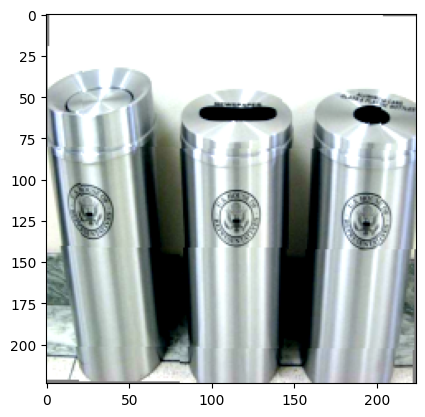

3
62


In [ ]:
## dataloader에 잘 올라가있는 지 확인하는 코드
def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
	# convert to Numpy
    npimg = img.numpy()
	# Transpose to get the correct color
    npimg=np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()


sample = next(iter(train_dataloader))
imshow(sample['image'][0])
print(sample['style'][0].item())
print(sample['item'][0].item())

##VERSION 1 Original

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
from collections import OrderedDict
from torchvision.models.resnet import BasicBlock
from torch.utils import model_zoo


class MixStyle(nn.Module):
    """MixStyle.

    Reference:
      Zhou et al. Domain Generalization with MixStyle. ICLR 2021.
    """

    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, mix='random'):
        """
        Args:
          p (float): probability of using MixStyle.
          alpha (float): parameter of the Beta distribution.
          eps (float): scaling parameter to avoid numerical issues.
          mix (str): how to mix.
        """
        super().__init__()
        self.p = p
        self.beta = torch.distributions.Beta(alpha, alpha)
        self.eps = eps
        self.alpha = alpha
        self.mix = mix
        self._activated = True

    def __repr__(self):
        return f'MixStyle(p={self.p}, alpha={self.alpha}, eps={self.eps}, mix={self.mix})'

    def set_activation_status(self, status=True):
        self._activated = status

    def update_mix_method(self, mix='random'):
        self.mix = mix

    def forward(self, x):
        if not self.training or not self._activated:
            return x

        if random.random() > self.p:
            return x

        B = x.size(0)

        mu = x.mean(dim=[2, 3], keepdim=True)
        var = x.var(dim=[2, 3], keepdim=True)
        sig = (var + self.eps).sqrt()
        mu, sig = mu.detach(), sig.detach()
        x_normed = (x-mu) / sig

        lmda = self.beta.sample((B, 1, 1, 1))

        # for i in range(B):
        #   if lmda[i].item() < 0.5:
        #     lmda[i] = 1 - lmda[i]

        lmda = lmda.to(x.device)

        if self.mix == 'random':
            # random shuffle
            perm = torch.randperm(B)
            #print(f'random apply perm{perm}')

        elif self.mix == 'crossdomain':
            # split into two halves and swap the order
            perm = torch.arange(B - 1, -1, -1) # inverse index
            perm_b, perm_a = perm.chunk(2)
            perm_b = perm_b[torch.randperm(B // 2)]
            perm_a = perm_a[torch.randperm(B // 2)]
            perm = torch.cat([perm_b, perm_a], 0)
            #print(f'pseudo crossdomain apply perm{perm}')

        else:
            raise NotImplementedError

        mu2, sig2 = mu[perm], sig[perm]
        mu_mix = mu*lmda + mu2 * (1-lmda)
        sig_mix = sig*lmda + sig2 * (1-lmda)

        return x_normed*sig_mix + mu_mix


from __future__ import division, absolute_import
import torch.utils.model_zoo as model_zoo
from torch import nn


__all__ = [
    'resnet18',
    'resnet50'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-11ad3fa6.pth'
}

'''
Reference : https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html
'''

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=1, stride=stride, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64'
            )
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock"
            )
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        groups = 1,
        base_width = 64,
        dilation = 1,
        norm_layer = None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        num_classes,
        loss,
        block,
        layers,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],
        mixstyle_p=0.5,
        mixstyle_alpha=0.1,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.loss = loss
        self.feature_dim = 512 * block.expansion
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".
                format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block,
            128,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block,
            256,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block,
            512,
            layers[3],
            stride=last_stride,
            dilate=replace_stride_with_dilation[2]
        )
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = self._construct_fc_layer(
            fc_dims, 512 * block.expansion, dropout_p
        )
        self.classifier = nn.Linear(self.feature_dim, num_classes)
        print(f"self.feature_dim {self.feature_dim}")

        self.mixstyle = None
        if mixstyle_layers:
            self.mixstyle = MixStyle(p=mixstyle_p, alpha=mixstyle_alpha, mix='random')
            print('Insert MixStyle after the following layers: {}'.format(mixstyle_layers))
        self.mixstyle_layers = mixstyle_layers

        self._init_params()

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
              if isinstance(m, BasicBlock):
                nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups,
                self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)

    def _construct_fc_layer(self, fc_dims, input_dim, dropout_p=None):

        if fc_dims is None:
            self.feature_dim = input_dim
            return None

        assert isinstance(
            fc_dims, (list, tuple)
        ), 'fc_dims must be either list or tuple, but got {}'.format(
            type(fc_dims)
        )

        layers = []
        for dim in fc_dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU(inplace=True))
            if dropout_p is not None:
                layers.append(nn.Dropout(p=dropout_p))
            input_dim = dim

        self.feature_dim = fc_dims[-1]

        return nn.Sequential(*layers)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu'
                )
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def featuremaps(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if 'layer1' in self.mixstyle_layers:
            x = self.mixstyle(x)

        x = self.layer2(x)
        if 'layer2' in self.mixstyle_layers:
            x = self.mixstyle(x)

        x = self.layer3(x)
        if 'layer3' in self.mixstyle_layers:
            x = self.mixstyle(x)

        x = self.layer4(x)

        return x

    def forward(self, x):
        f = self.featuremaps(x)
        v = self.global_avgpool(f)
        v = v.view(v.size(0), -1)

        if self.fc is not None:
            v = self.fc(v)

        if not self.training:
            return v

        y = self.classifier(v)

        if self.loss == 'softmax':
            return y
        else:
            raise KeyError("Unsupported loss: {}".format(self.loss))

class MultiTaskNet(nn.Module):
    def __init__(self, net, backbone,num_classes_style = 4, num_classes_item = 65, pretrained=True):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.net.classifier = nn.Identity()
        if backbone == "resnet18":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(512, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(512, 65))]))
        elif backbone == "resnet50":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(2048, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(2048, 65))]))



    def forward(self, x):
        x = self.net(x)
        style_head = self.net.fc1(x)
        item_head = self.net.fc2(x)

        return style_head, item_head

def init_pretrained_weights(model, model_url):
    """Initializes model with pretrained weights.

    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)



def resnet18(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=BasicBlock,
        layers=[2, 2, 2, 2],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],#'layer1', 'layer2', 'layer3'
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def resnet50(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=Bottleneck,
        layers=[3, 4, 6, 3],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],#'layer1', 'layer2'
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

backbone = ["resnet18" , "resnet50"]
model_pretrained_ = resnet50()
model_mixstyle_ = MultiTaskNet(model_pretrained_, backbone = "resnet50")
model_to_train = model_mixstyle_.to(device)

print(model_mixstyle_)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_to_train.parameters(), lr = 0.0004, weight_decay = 0.001)

def training_batch(train_loader, model,criterion, optimizer):
    model.train()

    training_loss = []
    training_style_loss = []
    training_item_loss = []

    for i, data in enumerate(train_loader):
      input = data["image"].to(device)
      style_label = data["style"].to(device)
      item_label = data["item"].to(device)

      optimizer.zero_grad()
      style_output, item_output = model(input)

      loss_1 = criterion(style_output, style_label)
      loss_2 = criterion(item_output, item_label)

      loss = loss_1 + loss_2

      loss.backward()
      optimizer.step()

      training_loss.append(loss.detach().item())
      training_style_loss.append(loss_1.detach().item())
      training_item_loss.append(loss_2.detach().item())


    return training_style_loss, training_item_loss

self.feature_dim 2048


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 296MB/s]


MultiTaskNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
def test_batch(data, model, criterion):
    model.eval()
    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input)
    loss_1 = criterion(style_output, style_label)
    loss_2 = criterion(item_output, item_label)

    total_loss = loss_1 + loss_2
    return  loss_1.item(), loss_2.item()

def accuracy(data, model):
    model.eval()

    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input)

    _, pred_label_style = style_output.max(-1)
    _, pred_label_item = item_output.max(-1)

    correct_style = (pred_label_style == style_label)
    correct_item = (pred_label_item == item_label)

    return correct_style.cpu().detach().numpy().tolist(), correct_item.cpu().detach().numpy().tolist()

In [ ]:
import torch
from torchmetrics.classification import MulticlassAveragePrecision

def classification_map(data_loader, model):
    # MulticlassAveragePrecision 메트릭스 초기화
    map_metric_style = MulticlassAveragePrecision(num_classes=4, average="macro")
    map_metric_item = MulticlassAveragePrecision(num_classes=65, average="macro")

    device = next(model.parameters()).device  # 모델의 디바이스 확인

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in data_loader:
            input = data["image"].to(device)
            style_true = data["style"].to(device)
            item_true = data["item"].to(device)

            style_pred, item_pred = model(input)

            # MulticlassAveragePrecision 클래스는 확률을 입력으로 받으므로 softmax를 적용하여 확률로 변환
            style_pred_prob = torch.softmax(style_pred, dim=1)
            item_pred_prob = torch.softmax(item_pred, dim=1)

            # 메트릭스 업데이트
            map_metric_style.update(style_pred_prob, style_true)
            map_metric_item.update(item_pred_prob, item_true)

    # 평균 정밀도 계산
    mAP_style = map_metric_style.compute()
    mAP_item = map_metric_item.compute()

    return mAP_style, mAP_item


In [ ]:
'''
Actual Training
'''

n_epochs = 20
scheduler = StepLR(optimizer, step_size=7, gamma=0.3)

train_loss_style, test_loss_style = [], []
train_loss_item, test_loss_item = [], []
train_accuracy_style, test_accuracy_style = [], []
train_accuracy_item, test_accuracy_item = [], []
all_precisions_style = []
all_recalls_style = []
all_precisions_item = []
all_recalls_item = []


for epoch in range(n_epochs):
    train_losses_style, train_losses_item = [], []
    test_losses_style,test_losses_item = [],[]

    train_accuracies_style, train_accuracies_item = [],[]
    test_accuracies_style, test_accuracies_item = [], []


    time1 = time.time()
    train_losses_style, train_losses_item = training_batch(train_dataloader, model_to_train, criterion, optimizer)

    for i, data in enumerate(train_dataloader):
        train_batch_correct_style, train_batch_correct_item = accuracy(data, model_to_train)
        train_accuracies_style.extend(train_batch_correct_style)
        train_accuracies_item.extend(train_batch_correct_item)


    train_per_epoch_loss_style = np.array(train_losses_style).mean()
    train_per_epoch_loss_item = np.array(train_losses_item).mean()
    train_per_epoch_accuracy_style = np.mean(train_accuracies_style)
    train_per_epoch_accuracy_item = np.mean(train_accuracies_item)

    #train_mAP_style, train_mAP_item = mean_average_precision(train_dataloader, model_to_train)
    #print("Test Mean Average Precision (Style):", train_mAP_style)
    #print("Test Mean Average Precision (Item):", train_mAP_item)

    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step()


    # with torch.no_grad():
    #   for i, data in enumerate(val_dataloader):
    #       val_batch_correct_style,val_batch_correct_item = accuracy(data, model_to_train)
    #       val_accuracies_style.extend(val_batch_correct_style)
    #       val_accuracies_item.extend(val_batch_correct_item)

    #   val_per_epoch_accuracy_style = np.mean(val_accuracies_style)
    #   val_per_epoch_accuracy_item = np.mean(val_accuracies_item)





    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        test_batch_loss_style, test_batch_loss_item = test_batch(data, model_to_train, criterion)
        test_losses_style.append(test_batch_loss_style)
        test_losses_item.append(test_batch_loss_item)

        test_batch_correct_style, test_batch_correct_item = accuracy(data , model_to_train)
        test_accuracies_style.extend(test_batch_correct_style)
        test_accuracies_item.extend(test_batch_correct_item)

    test_mAP_style, test_mAP_item  = classification_map(test_dataloader, model_to_train)
    #average_precision_style, average_recall_style, average_precision_item, average_recall_item = test_precision_recall( model_to_train, test_dataloader)

    #all_precisions_style.append(average_precision_style)
    #all_recalls_style.append(average_recall_style)

    #all_precisions_item.append(average_precision_item)
    #all_recalls_item.append(average_recall_item)




    test_per_epoch_loss_style = np.array(test_losses_style).mean()
    test_per_epoch_loss_item = np.array(test_losses_item).mean()
    test_per_epoch_accuracy_style = np.mean(test_accuracies_style)
    test_per_epoch_accuracy_item = np.mean(test_accuracies_item)



    # train, test
    # train_loss_style.append(train_per_epoch_loss_style)
    # train_accuracy_style.append(train_per_epoch_accuracy_style)

    # train_loss_item.append(train_per_epoch_loss_item)
    # train_accuracy_item.append(train_per_epoch_accuracy_item)

    # test_loss_style.append(test_per_epoch_loss_style)
    # test_accuracy_style.append(test_per_epoch_accuracy_style)

    # test_loss_item.append(test_per_epoch_loss_item)
    # test_accuracy_item.append(test_per_epoch_accuracy_item)



    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss style: {train_per_epoch_loss_style:.4f} | Training loss item : {train_per_epoch_loss_item:.4f}')
    print(f' Training accuracy style: {train_per_epoch_accuracy_style:.4f} |Training accuracy item: {train_per_epoch_accuracy_item:.4f} ', end='')
    print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}')
    print(f"Test Mean Average Precision (Style): {test_mAP_style} | Test Mean Average Precision (Item): {test_mAP_item}" + '\n')
    #print(f"Test Mean Average Precision (Style): {average_precision_style} | Test Mean Average Precision (Item): {average_precision_item}")
    #print(f"Test Mean Average Recall (Style): {average_recall_style} | Test Mean Average Recall (Item): {average_recall_item}")


'''
mean_precision_style = np.mean(all_precisions_style)
mean_recall_style = np.mean(all_recalls_style)
mean_precision_item =  np.mean(all_precisions_item)
mean_recall_item = np.mean(all_recalls_item)

  # 평균 성능 결과 출력
print("Mean Precision Style:", mean_precision_style)
print("Mean Recall Style:", mean_recall_style)
print("Mean Precision Style:", mean_precision_item)
print("Mean Recall Style:", mean_recall_item)
'''

    #print("Test Mean Average Precision (Style):", test_mAP_style)
    #print("Test Mean Average Precision (Item):", test_mAP_item)
    # print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}' + '\n')


Respective Execution time : 538.563346862793sec    1 epochs
Epoch: 1/20	| Training loss style: 0.6676 | Training loss item : 1.6600
 Training accuracy style: 0.8014 |Training accuracy item: 0.7986 Test loss style: 0.5831 | Test loss item: 0.9766 |  Test accuracy style: 0.7638 Test accuracy item: 0.7404
Test Mean Average Precision (Style): 0.8377708792686462 | Test Mean Average Precision (Item): 0.831500232219696

Respective Execution time : 547.4498507976532sec    2 epochs
Epoch: 2/20	| Training loss style: 0.4519 | Training loss item : 0.7173
 Training accuracy style: 0.8587 |Training accuracy item: 0.8646 Test loss style: 0.5204 | Test loss item: 0.8213 |  Test accuracy style: 0.7983 Test accuracy item: 0.7831
Test Mean Average Precision (Style): 0.8657757043838501 | Test Mean Average Precision (Item): 0.860031008720398

Respective Execution time : 548.7480638027191sec    3 epochs
Epoch: 3/20	| Training loss style: 0.3388 | Training loss item : 0.4831
 Training accuracy style: 0.8959

'\nmean_precision_style = np.mean(all_precisions_style)\nmean_recall_style = np.mean(all_recalls_style)\nmean_precision_item =  np.mean(all_precisions_item)\nmean_recall_item = np.mean(all_recalls_item)\n\n  # 평균 성능 결과 출력\nprint("Mean Precision Style:", mean_precision_style)\nprint("Mean Recall Style:", mean_recall_style)\nprint("Mean Precision Style:", mean_precision_item)\nprint("Mean Recall Style:", mean_recall_item)\n'

## VERSION 2 Modify Sampling function

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
from collections import OrderedDict
from torchvision.models.resnet import BasicBlock
from torch.utils import model_zoo


class MixStyle(nn.Module):
    """MixStyle.

    Reference:
      Zhou et al. Domain Generalization with MixStyle. ICLR 2021.
    """

    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, mix='random'):
        """
        Args:
          p (float): probability of using MixStyle.
          alpha (float): parameter of the Beta distribution.
          eps (float): scaling parameter to avoid numerical issues.
          mix (str): how to mix.
        """
        super().__init__()
        self.p = p
        self.beta = torch.distributions.Beta(alpha, alpha)
        self.eps = eps
        self.alpha = alpha
        self.mix = mix
        self._activated = True

    def __repr__(self):
        return f'MixStyle(p={self.p}, alpha={self.alpha}, eps={self.eps}, mix={self.mix})'

    def set_activation_status(self, status=True):
        self._activated = status

    def update_mix_method(self, mix='random'):
        self.mix = mix

    def forward(self, x):
        if not self.training or not self._activated:
            return x

        if random.random() > self.p:
            return x

        B = x.size(0)

        mu = x.mean(dim=[2, 3], keepdim=True)
        var = x.var(dim=[2, 3], keepdim=True)
        sig = (var + self.eps).sqrt()
        mu, sig = mu.detach(), sig.detach()
        x_normed = (x-mu) / sig

        lmda = self.beta.sample((B, 1, 1, 1))

        for i in range(B):
            if lmda[i].item() < 0.5:
                lmda[i] = 1 - lmda[i]

        lmda = lmda.to(x.device)

        if self.mix == 'random':
            # random shuffle
            perm = torch.randperm(B)
            #print(f'random apply perm{perm}')

        elif self.mix == 'crossdomain':
            # split into two halves and swap the order
            perm = torch.arange(B - 1, -1, -1) # inverse index
            perm_b, perm_a = perm.chunk(2)
            perm_b = perm_b[torch.randperm(B // 2)]
            perm_a = perm_a[torch.randperm(B // 2)]
            perm = torch.cat([perm_b, perm_a], 0)
            #print(f'pseudo crossdomain apply perm{perm}')

        else:
            raise NotImplementedError

        mu2, sig2 = mu[perm], sig[perm]
        mu_mix = mu*lmda + mu2 * (1-lmda)
        sig_mix = sig*lmda + sig2 * (1-lmda)

        return x_normed*sig_mix + mu_mix


from __future__ import division, absolute_import
import torch.utils.model_zoo as model_zoo
from torch import nn


__all__ = [
    'resnet18',
    'resnet50'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-11ad3fa6.pth'
}

'''
Reference : https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html
'''

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=1, stride=stride, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64'
            )
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock"
            )
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        groups = 1,
        base_width = 64,
        dilation = 1,
        norm_layer = None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        num_classes,
        loss,
        block,
        layers,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],
        mixstyle_p=0.5,
        mixstyle_alpha=0.1,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.loss = loss
        self.feature_dim = 512 * block.expansion
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".
                format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block,
            128,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block,
            256,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block,
            512,
            layers[3],
            stride=last_stride,
            dilate=replace_stride_with_dilation[2]
        )
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = self._construct_fc_layer(
            fc_dims, 512 * block.expansion, dropout_p
        )
        self.classifier = nn.Linear(self.feature_dim, num_classes)
        print(f"self.feature_dim {self.feature_dim}")

        self.mixstyle = None
        if mixstyle_layers:
            self.mixstyle = MixStyle(p=mixstyle_p, alpha=mixstyle_alpha, mix='random')
            print('Insert MixStyle after the following layers: {}'.format(mixstyle_layers))
        self.mixstyle_layers = mixstyle_layers

        self._init_params()

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
              if isinstance(m, BasicBlock):
                nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups,
                self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)

    def _construct_fc_layer(self, fc_dims, input_dim, dropout_p=None):

        if fc_dims is None:
            self.feature_dim = input_dim
            return None

        assert isinstance(
            fc_dims, (list, tuple)
        ), 'fc_dims must be either list or tuple, but got {}'.format(
            type(fc_dims)
        )

        layers = []
        for dim in fc_dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU(inplace=True))
            if dropout_p is not None:
                layers.append(nn.Dropout(p=dropout_p))
            input_dim = dim

        self.feature_dim = fc_dims[-1]

        return nn.Sequential(*layers)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu'
                )
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def featuremaps(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if 'layer1' in self.mixstyle_layers:
            x = self.mixstyle(x)

        x = self.layer2(x)
        if 'layer2' in self.mixstyle_layers:
            x = self.mixstyle(x)

        x = self.layer3(x)
        if 'layer3' in self.mixstyle_layers:
            x = self.mixstyle(x)

        x = self.layer4(x)

        return x

    def forward(self, x):
        f = self.featuremaps(x)
        v = self.global_avgpool(f)
        v = v.view(v.size(0), -1)

        if self.fc is not None:
            v = self.fc(v)

        if not self.training:
            return v

        y = self.classifier(v)

        if self.loss == 'softmax':
            return y
        else:
            raise KeyError("Unsupported loss: {}".format(self.loss))

class MultiTaskNet(nn.Module):
    def __init__(self, net, backbone, num_classes_style = 4, num_classes_item = 65, pretrained=True):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.net.classifier = nn.Identity()
        if backbone == "resnet18":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 65))]))
        elif backbone == "resnet50":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 65))]))



    def forward(self, x):
        x = self.net(x)
        style_head = self.net.fc1(x)
        item_head = self.net.fc2(x)

        return style_head, item_head

def init_pretrained_weights(model, model_url):
    """Initializes model with pretrained weights.

    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)



def resnet18(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=BasicBlock,
        layers=[2, 2, 2, 2],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2', 'layer3'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def resnet50(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=Bottleneck,
        layers=[3, 4, 6, 3],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

backbone = ["resnet18" , "resnet50"]

model_pretrained_ = resnet50()
model_mixstyle_ = MultiTaskNet(model_pretrained_,backbone = "resnet50")
model_to_train = model_mixstyle_.to(device)

print(model_mixstyle_)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_to_train.parameters(), lr = 0.0004, weight_decay = 0.001)

def training_batch(train_loader, model,criterion, optimizer):
    model.train()

    training_loss = []
    training_style_loss = []
    training_item_loss = []

    for i, data in enumerate(train_loader):
      input = data["image"].to(device)
      style_label = data["style"].to(device)
      item_label = data["item"].to(device)

      optimizer.zero_grad()
      style_output, item_output = model(input)

      loss_1 = criterion(style_output, style_label)
      loss_2 = criterion(item_output, item_label)

      loss = loss_1 + loss_2

      loss.backward()
      optimizer.step()

      training_loss.append(loss.detach().item())
      training_style_loss.append(loss_1.detach().item())
      training_item_loss.append(loss_2.detach().item())


    return training_style_loss, training_item_loss

In [ ]:
def test_batch(data, model, criterion):
    model.eval()
    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input)
    loss_1 = criterion(style_output, style_label)
    loss_2 = criterion(item_output, item_label)

    total_loss = loss_1 + loss_2
    return  loss_1.item(), loss_2.item()

def accuracy(data, model):
    model.eval()

    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input)

    _, pred_label_style = style_output.max(-1)
    _, pred_label_item = item_output.max(-1)

    correct_style = (pred_label_style == style_label)
    correct_item = (pred_label_item == item_label)

    return correct_style.cpu().detach().numpy().tolist(), correct_item.cpu().detach().numpy().tolist()

In [ ]:
import torch
from torchmetrics.classification import MulticlassAveragePrecision

def classification_map(data_loader, model):
    # MulticlassAveragePrecision 메트릭스 초기화
    map_metric_style = MulticlassAveragePrecision(num_classes=4, average="macro")
    map_metric_item = MulticlassAveragePrecision(num_classes=65, average="macro")

    device = next(model.parameters()).device  # 모델의 디바이스 확인

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in data_loader:
            input = data["image"].to(device)
            style_true = data["style"].to(device)
            item_true = data["item"].to(device)

            style_pred, item_pred = model(input)

            # MulticlassAveragePrecision 클래스는 확률을 입력으로 받으므로 softmax를 적용하여 확률로 변환
            style_pred_prob = torch.softmax(style_pred, dim=1)
            item_pred_prob = torch.softmax(item_pred, dim=1)

            # 메트릭스 업데이트
            map_metric_style.update(style_pred_prob, style_true)
            map_metric_item.update(item_pred_prob, item_true)

    # 평균 정밀도 계산
    mAP_style = map_metric_style.compute()
    mAP_item = map_metric_item.compute()

    return mAP_style, mAP_item


In [ ]:
'''
Actual Training
'''

n_epochs = 10
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

train_loss_style, test_loss_style = [], []
train_loss_item, test_loss_item = [], []
train_accuracy_style, test_accuracy_style = [], []
train_accuracy_item, test_accuracy_item = [], []
all_precisions_style = []
all_recalls_style = []
all_precisions_item = []
all_recalls_item = []


for epoch in range(n_epochs):
    train_losses_style, train_losses_item = [], []
    test_losses_style,test_losses_item = [],[]

    train_accuracies_style, train_accuracies_item = [],[]
    test_accuracies_style, test_accuracies_item = [], []


    time1 = time.time()
    train_losses_style, train_losses_item = training_batch(train_dataloader, model_to_train, criterion, optimizer)

    for i, data in enumerate(train_dataloader):
        train_batch_correct_style, train_batch_correct_item = accuracy(data, model_to_train)
        train_accuracies_style.extend(train_batch_correct_style)
        train_accuracies_item.extend(train_batch_correct_item)


    train_per_epoch_loss_style = np.array(train_losses_style).mean()
    train_per_epoch_loss_item = np.array(train_losses_item).mean()
    train_per_epoch_accuracy_style = np.mean(train_accuracies_style)
    train_per_epoch_accuracy_item = np.mean(train_accuracies_item)

    #train_mAP_style, train_mAP_item = mean_average_precision(train_dataloader, model_to_train)
    #print("Test Mean Average Precision (Style):", train_mAP_style)
    #print("Test Mean Average Precision (Item):", train_mAP_item)

    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step()


    # with torch.no_grad():
    #   for i, data in enumerate(val_dataloader):
    #       val_batch_correct_style,val_batch_correct_item = accuracy(data, model_to_train)
    #       val_accuracies_style.extend(val_batch_correct_style)
    #       val_accuracies_item.extend(val_batch_correct_item)

    #   val_per_epoch_accuracy_style = np.mean(val_accuracies_style)
    #   val_per_epoch_accuracy_item = np.mean(val_accuracies_item)





    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        test_batch_loss_style, test_batch_loss_item = test_batch(data, model_to_train, criterion)
        test_losses_style.append(test_batch_loss_style)
        test_losses_item.append(test_batch_loss_item)

        test_batch_correct_style, test_batch_correct_item = accuracy(data , model_to_train)
        test_accuracies_style.extend(test_batch_correct_style)
        test_accuracies_item.extend(test_batch_correct_item)

    test_mAP_style, test_mAP_item  = classification_map(test_dataloader, model_to_train)
    #average_precision_style, average_recall_style, average_precision_item, average_recall_item = test_precision_recall( model_to_train, test_dataloader)

    #all_precisions_style.append(average_precision_style)
    #all_recalls_style.append(average_recall_style)

    #all_precisions_item.append(average_precision_item)
    #all_recalls_item.append(average_recall_item)




    test_per_epoch_loss_style = np.array(test_losses_style).mean()
    test_per_epoch_loss_item = np.array(test_losses_item).mean()
    test_per_epoch_accuracy_style = np.mean(test_accuracies_style)
    test_per_epoch_accuracy_item = np.mean(test_accuracies_item)



    # train, test
    # train_loss_style.append(train_per_epoch_loss_style)
    # train_accuracy_style.append(train_per_epoch_accuracy_style)

    # train_loss_item.append(train_per_epoch_loss_item)
    # train_accuracy_item.append(train_per_epoch_accuracy_item)

    # test_loss_style.append(test_per_epoch_loss_style)
    # test_accuracy_style.append(test_per_epoch_accuracy_style)

    # test_loss_item.append(test_per_epoch_loss_item)
    # test_accuracy_item.append(test_per_epoch_accuracy_item)



    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss style: {train_per_epoch_loss_style:.4f} | Training loss item : {train_per_epoch_loss_item:.4f}')
    print(f' Training accuracy style: {train_per_epoch_accuracy_style:.4f} |Training accuracy item: {train_per_epoch_accuracy_item:.4f} ', end='')
    print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}')
    print(f"Test Mean Average Precision (Style): {test_mAP_style} | Test Mean Average Precision (Item): {test_mAP_item}" + '\n')
    #print(f"Test Mean Average Precision (Style): {average_precision_style} | Test Mean Average Precision (Item): {average_precision_item}")
    #print(f"Test Mean Average Recall (Style): {average_recall_style} | Test Mean Average Recall (Item): {average_recall_item}")


'''
mean_precision_style = np.mean(all_precisions_style)
mean_recall_style = np.mean(all_recalls_style)
mean_precision_item =  np.mean(all_precisions_item)
mean_recall_item = np.mean(all_recalls_item)

  # 평균 성능 결과 출력
print("Mean Precision Style:", mean_precision_style)
print("Mean Recall Style:", mean_recall_style)
print("Mean Precision Style:", mean_precision_item)
print("Mean Recall Style:", mean_recall_item)
'''

    #print("Test Mean Average Precision (Style):", test_mAP_style)
    #print("Test Mean Average Precision (Item):", test_mAP_item)
    # print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}' + '\n')


##VERSION 3 using Domain label

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
from collections import OrderedDict
from torchvision.models.resnet import BasicBlock
from torch.utils import model_zoo


class MixStyle(nn.Module):
    """MixStyle.

    Reference:
      Zhou et al. Domain Generalization with MixStyle. ICLR 2021.
    """

    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, mix='random'):
        """
        Args:
          p (float): probability of using MixStyle.
          alpha (float): parameter of the Beta distribution.
          eps (float): scaling parameter to avoid numerical issues.
          mix (str): how to mix.
        """
        super().__init__()
        self.p = p
        self.beta = torch.distributions.Beta(alpha, alpha)
        self.eps = eps
        self.alpha = alpha
        self.mix = mix
        self._activated = True
        self.lmda = None
        self.perm = None

    def __repr__(self):
        return f'MixStyle(p={self.p}, alpha={self.alpha}, eps={self.eps}, mix={self.mix})'

    def set_activation_status(self, status=True):
        self._activated = status

    def update_mix_method(self, mix='random'):
        self.mix = mix

    def forward(self, x , perm):

        if not self.training or not self._activated:
            return x

        if random.random() > self.p:
            self.lmda = torch.full((x.size()[0], 1, 1, 1), 1)
            #self.perm = torch.arange(1, 65)
            return x




        B = x.size(0)

        mu = x.mean(dim=[2, 3], keepdim=True)
        var = x.var(dim=[2, 3], keepdim=True)
        sig = (var + self.eps).sqrt()
        mu, sig = mu.detach(), sig.detach()
        x_normed = (x-mu) / sig


        sampled = self.beta.sample()

        if sampled < 0.5 :
          sampled = 1- sampled
        lmda = torch.full((x.size()[0], 1, 1, 1), sampled)

        self.lmda = lmda.to(x.device)

        #lmda = self.beta.sample((B, 1, 1, 1))
        #lmda = torch.tensor(lmda)
        # for i in range(B):
        #   if lmda[i].item() < 0.5:
        #     lmda[i] = 1 - lmda[i]

        #print(f"lmda : {lmda}")


        mu2, sig2 = mu[perm], sig[perm]
        mu_mix = mu*self.lmda + mu2 * (1-self.lmda)
        sig_mix = sig*self.lmda + sig2 * (1-self.lmda)

        return x_normed*sig_mix + mu_mix


from __future__ import division, absolute_import
import torch.utils.model_zoo as model_zoo
from torch import nn


__all__ = [
    'resnet18',
    'resnet50'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-11ad3fa6.pth'
}

'''
Reference : https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html
'''

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=1, stride=stride, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64'
            )
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock"
            )
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        groups = 1,
        base_width = 64,
        dilation = 1,
        norm_layer = None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        num_classes,
        loss,
        block,
        layers,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],
        mixstyle_p=0.5,
        mixstyle_alpha=0.1,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.loss = loss
        self.feature_dim = 512 * block.expansion
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(

                format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block,
            128,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block,
            256,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block,
            512,
            layers[3],
            stride=last_stride,
            dilate=replace_stride_with_dilation[2]
        )
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


        self.mixstyle = MixStyle(p=mixstyle_p, alpha=mixstyle_alpha, mix='random')
        self.mixstyle_layers = mixstyle_layers

        self.lmda_1 = None

        self.lmda_2 = None

        self.lmda_3 = torch.full((64, 1, 1, 1), 1)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups,
                self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)





    def forward(self, x, perm_1, perm_2, perm_3):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if 'layer1' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_1)
            #print(self.mixstyle.lmda_1)
            #print(self.mixstyle.perm_1)
            self.lmda_1 = self.mixstyle.lmda

        x = self.layer2(x)
        if 'layer2' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_2)
            self.lmda_2 = self.mixstyle.lmda

        x = self.layer3(x)
        if 'layer3' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_3)
            self.lmda_3 = self.mixstyle.lmda

        f = self.layer4(x)
        v = self.global_avgpool(f)
        v = v.view(v.size(0), -1)

        y = self.fc(v)

        return y

class MultiTaskNet(nn.Module):
    def __init__(self, net, backbone, num_classes_style = 4, num_classes_item = 65, pretrained=True ):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.net.fc = nn.Identity()

        if backbone == "resnet18":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 65))]))
        elif backbone == "resnet50":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 65))]))


    def forward(self, x, perm_1, perm_2, perm_3):
        x = self.net(x, perm_1, perm_2, perm_3)
        style_head = self.net.fc1(x)
        item_head = self.net.fc2(x)
        #print(self.net.lmda_1)
        #print(self.net.perm_1)

        #print(self.net.mixstyle.lmda)
        #print(self.net.mixstyle.perm)

        return style_head, item_head

def init_pretrained_weights(model, model_url):
    """Initializes model with pretrained weights.

    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)



def resnet18(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=BasicBlock,
        layers=[2, 2, 2, 2],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2', 'layer3'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def resnet50(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=Bottleneck,
        layers=[3, 4, 6, 3],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

backbone = ["resnet18" , "resnet50"]

model_pretrained_ = resnet50()
model_mixstyle_ = MultiTaskNet(model_pretrained_, backbone = "resnet50")
model_to_train = model_mixstyle_.to(device)

print(model_mixstyle_)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_to_train.parameters(), lr = 0.0004, weight_decay = 0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


MultiTaskNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
'''
Train and Test function
'''
def training_batch(train_loader, model,criterion, optimizer):
    model.train()

    training_loss = []
    training_style_loss = []
    training_item_loss = []


    for i, data in enumerate(train_loader):
      input = data["image"].to(device)
      style_label_ = data["style"]
      style_label = style_label_.to(device)
      item_label = data["item"].to(device)


      optimizer.zero_grad()
      rand_index_1 = torch.randperm(input.size()[0]).cuda()
      rand_index_2 = torch.randperm(input.size()[0]).cuda()
      rand_index_3 = torch.randperm(input.size()[0]).cuda()

      style_output, item_output = model(input, rand_index_1, rand_index_2, rand_index_3)

      #####labelling#####
      if(model.net.lmda_1[0] != None):
        lmda_1 = float(model.net.lmda_1[0])
      if(model.net.lmda_2[0] != None):
        lmda_2 = float(model.net.lmda_2[0])
      # if(model.net.lmda_3[0] != None):
      #   lmda_3 = float(model.net.lmda_3[0])


      style_label_a = style_label[rand_index_1]
      style_label_b = style_label[rand_index_2]
      #style_label_c = style_label[rand_index_3]


      loss_style_temp1 = criterion(style_output, style_label_a)
      loss_style_temp2 = criterion(style_output, style_label_b)
      #loss_style_temp3 = criterion(style_output, style_label_c)

      loss_style_original = criterion(style_output, style_label)

      #loss_style = lmda_3 * (lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2) + (1 - lmda_3) * loss_style_temp3
      loss_style = lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2


      loss_item = criterion(item_output, item_label)

      loss = loss_style + loss_item

      loss.backward()
      optimizer.step()

      training_loss.append(loss.detach().item())
      training_style_loss.append(loss_style_original.detach().item())
      training_item_loss.append(loss_item.detach().item())

      # print(f"lmda_1 : {lmda_1}")
      # print(f"lmda_2 : {lmda_2}")
      # print(f"lmda_3 : {lmda_3}")


    return training_style_loss, training_item_loss

'''
def training_batch_with_cutmix(train_loader, model, criterion, optimizer):
    model.train()
    beta = 1.0
    cutmix_prob = 0.5

    for _, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        r = np.random.rand(1)

        if beta > int(0.0) and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(input.size()[0]).cuda()
            target_a = target # target이 label
            target_b = target[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
            input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
                # compute output
            output = model(input)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
        else:
            # compute output
            output = model(input)
            loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

    for data, labels in train_loader:
        training_accuracies.extend(accuracy(data, labels, model))
'''

def test_batch(data, model, criterion):
    model.eval()
    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)
    loss_1 = criterion(style_output, style_label)
    loss_2 = criterion(item_output, item_label)

    total_loss = loss_1 + loss_2
    return  loss_1.item(), loss_2.item()

def accuracy(data, model):
    model.eval()

    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)

    _, pred_label_style = style_output.max(-1)
    _, pred_label_item = item_output.max(-1)

    correct_style = (pred_label_style == style_label)
    correct_item = (pred_label_item == item_label)

    return correct_style.cpu().detach().numpy().tolist(), correct_item.cpu().detach().numpy().tolist()


'''
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()
'''

'\n    data = data.to(device)\n    labels = labels.to(device)\n    output = model(data)\n    _, pred_labels = output.max(-1)\n    correct = (pred_labels == labels)\n    return correct.cpu().detach().numpy().tolist()\n'

In [ ]:
import torch
from torchmetrics.classification import MulticlassAveragePrecision

def classification_map(data_loader, model):
    # MulticlassAveragePrecision 메트릭스 초기화
    map_metric_style = MulticlassAveragePrecision(num_classes=4, average="macro")
    map_metric_item = MulticlassAveragePrecision(num_classes=65, average="macro")

    device = next(model.parameters()).device  # 모델의 디바이스 확인

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in data_loader:
            input = data["image"].to(device)
            style_true = data["style"].to(device)
            item_true = data["item"].to(device)

            style_pred, item_pred = model(input,None, None, None)

            # MulticlassAveragePrecision 클래스는 확률을 입력으로 받으므로 softmax를 적용하여 확률로 변환
            style_pred_prob = torch.softmax(style_pred, dim=1)
            item_pred_prob = torch.softmax(item_pred, dim=1)

            # 메트릭스 업데이트
            map_metric_style.update(style_pred_prob, style_true)
            map_metric_item.update(item_pred_prob, item_true)

    # 평균 정밀도 계산
    mAP_style = map_metric_style.compute()
    mAP_item = map_metric_item.compute()

    return mAP_style, mAP_item


In [ ]:
'''
Actual Training
'''

n_epochs = 10
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

train_loss_style, test_loss_style = [], []
train_loss_item, test_loss_item = [], []
train_accuracy_style, test_accuracy_style = [], []
train_accuracy_item, test_accuracy_item = [], []
all_precisions_style = []
all_recalls_style = []
all_precisions_item = []
all_recalls_item = []


for epoch in range(n_epochs):
    train_losses_style, train_losses_item = [], []
    test_losses_style,test_losses_item = [],[]

    train_accuracies_style, train_accuracies_item = [],[]
    test_accuracies_style, test_accuracies_item = [], []


    time1 = time.time()
    train_losses_style, train_losses_item = training_batch(train_dataloader, model_to_train, criterion, optimizer)

    for i, data in enumerate(train_dataloader):
        train_batch_correct_style, train_batch_correct_item = accuracy(data, model_to_train)
        train_accuracies_style.extend(train_batch_correct_style)
        train_accuracies_item.extend(train_batch_correct_item)


    train_per_epoch_loss_style = np.array(train_losses_style).mean()
    train_per_epoch_loss_item = np.array(train_losses_item).mean()
    train_per_epoch_accuracy_style = np.mean(train_accuracies_style)
    train_per_epoch_accuracy_item = np.mean(train_accuracies_item)

    #train_mAP_style, train_mAP_item = mean_average_precision(train_dataloader, model_to_train)
    #print("Test Mean Average Precision (Style):", train_mAP_style)
    #print("Test Mean Average Precision (Item):", train_mAP_item)

    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step()


    # with torch.no_grad():
    #   for i, data in enumerate(val_dataloader):
    #       val_batch_correct_style,val_batch_correct_item = accuracy(data, model_to_train)
    #       val_accuracies_style.extend(val_batch_correct_style)
    #       val_accuracies_item.extend(val_batch_correct_item)

    #   val_per_epoch_accuracy_style = np.mean(val_accuracies_style)
    #   val_per_epoch_accuracy_item = np.mean(val_accuracies_item)





    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        test_batch_loss_style, test_batch_loss_item = test_batch(data, model_to_train, criterion)
        test_losses_style.append(test_batch_loss_style)
        test_losses_item.append(test_batch_loss_item)

        test_batch_correct_style, test_batch_correct_item = accuracy(data , model_to_train)
        test_accuracies_style.extend(test_batch_correct_style)
        test_accuracies_item.extend(test_batch_correct_item)

    test_mAP_style, test_mAP_item  = classification_map(test_dataloader, model_to_train)
    #average_precision_style, average_recall_style, average_precision_item, average_recall_item = test_precision_recall( model_to_train, test_dataloader)

    #all_precisions_style.append(average_precision_style)
    #all_recalls_style.append(average_recall_style)

    #all_precisions_item.append(average_precision_item)
    #all_recalls_item.append(average_recall_item)




    test_per_epoch_loss_style = np.array(test_losses_style).mean()
    test_per_epoch_loss_item = np.array(test_losses_item).mean()
    test_per_epoch_accuracy_style = np.mean(test_accuracies_style)
    test_per_epoch_accuracy_item = np.mean(test_accuracies_item)



    # train, test
    # train_loss_style.append(train_per_epoch_loss_style)
    # train_accuracy_style.append(train_per_epoch_accuracy_style)

    # train_loss_item.append(train_per_epoch_loss_item)
    # train_accuracy_item.append(train_per_epoch_accuracy_item)

    # test_loss_style.append(test_per_epoch_loss_style)
    # test_accuracy_style.append(test_per_epoch_accuracy_style)

    # test_loss_item.append(test_per_epoch_loss_item)
    # test_accuracy_item.append(test_per_epoch_accuracy_item)



    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss style: {train_per_epoch_loss_style:.4f} | Training loss item : {train_per_epoch_loss_item:.4f}')
    print(f' Training accuracy style: {train_per_epoch_accuracy_style:.4f} |Training accuracy item: {train_per_epoch_accuracy_item:.4f} ', end='')
    print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}')
    print(f"Test Mean Average Precision (Style): {test_mAP_style} | Test Mean Average Precision (Item): {test_mAP_item}" + '\n')
    #print(f"Test Mean Average Precision (Style): {average_precision_style} | Test Mean Average Precision (Item): {average_precision_item}")
    #print(f"Test Mean Average Recall (Style): {average_recall_style} | Test Mean Average Recall (Item): {average_recall_item}")


'''
mean_precision_style = np.mean(all_precisions_style)
mean_recall_style = np.mean(all_recalls_style)
mean_precision_item =  np.mean(all_precisions_item)
mean_recall_item = np.mean(all_recalls_item)

  # 평균 성능 결과 출력
print("Mean Precision Style:", mean_precision_style)
print("Mean Recall Style:", mean_recall_style)
print("Mean Precision Style:", mean_precision_item)
print("Mean Recall Style:", mean_recall_item)
'''

    #print("Test Mean Average Precision (Style):", test_mAP_style)
    #print("Test Mean Average Precision (Item):", test_mAP_item)
    # print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}' + '\n')


Respective Execution time : 562.4271512031555sec    1 epochs
Epoch: 1/10	| Training loss style: 0.6825 | Training loss item : 1.4756
 Training accuracy style: 0.7997 |Training accuracy item: 0.7996 Test loss style: 0.6101 | Test loss item: 1.0027 |  Test accuracy style: 0.7644 Test accuracy item: 0.7314
Test Mean Average Precision (Style): 0.8286006450653076 | Test Mean Average Precision (Item): 0.8217507600784302

Respective Execution time : 560.2008926868439sec    2 epochs
Epoch: 2/10	| Training loss style: 0.4775 | Training loss item : 0.6194
 Training accuracy style: 0.8536 |Training accuracy item: 0.8844 Test loss style: 0.5094 | Test loss item: 0.7979 |  Test accuracy style: 0.8080 Test accuracy item: 0.7893
Test Mean Average Precision (Style): 0.8700501322746277 | Test Mean Average Precision (Item): 0.8696520328521729

Respective Execution time : 569.5523674488068sec    3 epochs
Epoch: 3/10	| Training loss style: 0.3922 | Training loss item : 0.3985
 Training accuracy style: 0.8

'\nmean_precision_style = np.mean(all_precisions_style)\nmean_recall_style = np.mean(all_recalls_style)\nmean_precision_item =  np.mean(all_precisions_item)\nmean_recall_item = np.mean(all_recalls_item)\n\n  # 평균 성능 결과 출력\nprint("Mean Precision Style:", mean_precision_style)\nprint("Mean Recall Style:", mean_recall_style)\nprint("Mean Precision Style:", mean_precision_item)\nprint("Mean Recall Style:", mean_recall_item)\n'

##VERSION 4 Freeze Initial Stage

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
from collections import OrderedDict
from torchvision.models.resnet import BasicBlock
from torch.utils import model_zoo


class MixStyle(nn.Module):
    """MixStyle.

    Reference:
      Zhou et al. Domain Generalization with MixStyle. ICLR 2021.
    """

    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, mix='random'):
        """
        Args:
          p (float): probability of using MixStyle.
          alpha (float): parameter of the Beta distribution.
          eps (float): scaling parameter to avoid numerical issues.
          mix (str): how to mix.
        """
        super().__init__()
        self.p = p
        self.beta = torch.distributions.Beta(alpha, alpha)
        self.eps = eps
        self.alpha = alpha
        self.mix = mix
        self._activated = True
        self.lmda = None
        self.perm = None

    def __repr__(self):
        return f'MixStyle(p={self.p}, alpha={self.alpha}, eps={self.eps}, mix={self.mix})'

    def set_activation_status(self, status=True):
        self._activated = status

    def update_mix_method(self, mix='random'):
        self.mix = mix

    def forward(self, x , perm):

        if not self.training or not self._activated:
            return x

        if random.random() > self.p:
            self.lmda = torch.full((x.size()[0], 1, 1, 1), 1)
            #self.perm = torch.arange(1, 65)
            return x




        B = x.size(0)

        mu = x.mean(dim=[2, 3], keepdim=True)
        var = x.var(dim=[2, 3], keepdim=True)
        sig = (var + self.eps).sqrt()
        mu, sig = mu.detach(), sig.detach()
        x_normed = (x-mu) / sig


        sampled = self.beta.sample()

        if sampled < 0.5 :
          sampled = 1- sampled
        lmda = torch.full((x.size()[0], 1, 1, 1), sampled)

        self.lmda = lmda.to(x.device)

        #lmda = self.beta.sample((B, 1, 1, 1))
        #lmda = torch.tensor(lmda)
        # for i in range(B):
        #   if lmda[i].item() < 0.5:
        #     lmda[i] = 1 - lmda[i]

        #print(f"lmda : {lmda}")


        mu2, sig2 = mu[perm], sig[perm]
        mu_mix = mu*self.lmda + mu2 * (1-self.lmda)
        sig_mix = sig*self.lmda + sig2 * (1-self.lmda)

        return x_normed*sig_mix + mu_mix


from __future__ import division, absolute_import
import torch.utils.model_zoo as model_zoo
from torch import nn


__all__ = [
    'resnet18',
    'resnet50'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-11ad3fa6.pth'
}

'''
Reference : https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html
'''

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=1, stride=stride, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64'
            )
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock"
            )
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        groups = 1,
        base_width = 64,
        dilation = 1,
        norm_layer = None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        num_classes,
        loss,
        block,
        layers,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],
        mixstyle_p=0.5,
        mixstyle_alpha=0.1,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.loss = loss
        self.feature_dim = 512 * block.expansion
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(

                format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block,
            128,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block,
            256,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block,
            512,
            layers[3],
            stride=last_stride,
            dilate=replace_stride_with_dilation[2]
        )
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


        self.mixstyle = MixStyle(p=mixstyle_p, alpha=mixstyle_alpha, mix='random')
        self.mixstyle_layers = mixstyle_layers

        self.lmda_1 = None

        self.lmda_2 = None

        self.lmda_3 = None


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups,
                self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)





    def forward(self, x, perm_1, perm_2, perm_3):
        for param in self.conv1.parameters():
            param.requires_grad = False
        for param in self.bn1.parameters():
            param.requires_grad = False
        for param in self.relu.parameters():
            param.requires_grad = False
        for param in self.maxpool.parameters():
            param.requires_grad = False
        for param in self.layer1.parameters():
            param.requires_grad = False

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if 'layer1' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_1)
            #print(self.mixstyle.lmda_1)
            #print(self.mixstyle.perm_1)
            self.lmda_1 = self.mixstyle.lmda

        x = self.layer2(x)
        if 'layer2' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_2)
            self.lmda_2 = self.mixstyle.lmda

        x = self.layer3(x)
        if 'layer3' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_3)
            self.lmda_3 = self.mixstyle.lmda

        f = self.layer4(x)
        v = self.global_avgpool(f)
        v = v.view(v.size(0), -1)

        y = self.fc(v)

        return y

class MultiTaskNet(nn.Module):
    def __init__(self, net, backbone, num_classes_style = 4, num_classes_item = 65, pretrained=True ):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.net.fc = nn.Identity()

        if backbone == "resnet18":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(512, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(512, 65))]))
        elif backbone == "resnet50":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(2048, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('dropout1', nn.Dropout(0.5)),('final', nn.Linear(2048, 65))]))


    def forward(self, x, perm_1, perm_2, perm_3):
        x = self.net(x, perm_1, perm_2, perm_3)
        style_head = self.net.fc1(x)
        item_head = self.net.fc2(x)
        #print(self.net.lmda_1)
        #print(self.net.perm_1)

        #print(self.net.mixstyle.lmda)
        #print(self.net.mixstyle.perm)

        return style_head, item_head

def init_pretrained_weights(model, model_url):
    """Initializes model with pretrained weights.

    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)



def resnet18(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=BasicBlock,
        layers=[2, 2, 2, 2],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2', 'layer3'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def resnet50(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=Bottleneck,
        layers=[3, 4, 6, 3],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

backbone = ["resnet18" , "resnet50"]
# 특정 레이어를 freeze
freeze_layers = ['layer1', 'layer2']  # freeze하고 싶은 레이어 명세



'''
for name, child in model_pretrain.named_children():
    if name in freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# 특정 레이어의 원하는 파라미터를 선택적으로 freeze
for name, child in model_pretrain.named_children():
    if name == 'layer1':
        for param_name, param in child.named_parameters():
            # 특정 조건에 따라 파라미터 freeze
            if 'bn' in param_name:  # 'bn'이 포함된 파라미터만 선택
                param.requires_grad = False
'''

model_pretrained_ = resnet50()
model_mixstyle_ = MultiTaskNet(model_pretrained_, backbone = "resnet50")
model_to_train = model_mixstyle_.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_to_train.parameters(), lr = 0.0004, weight_decay = 0.001)

In [ ]:
'''
Train and Test function
'''
def training_batch(train_loader, model,criterion, optimizer):
    model.train()

    training_loss = []
    training_style_loss = []
    training_item_loss = []


    for i, data in enumerate(train_loader):
      input = data["image"].to(device)
      style_label_ = data["style"]
      style_label = style_label_.to(device)
      item_label = data["item"].to(device)


      optimizer.zero_grad()
      rand_index_1 = torch.randperm(input.size()[0]).cuda()
      rand_index_2 = torch.randperm(input.size()[0]).cuda()
      rand_index_3 = torch.randperm(input.size()[0]).cuda()

      style_output, item_output = model(input, rand_index_1, rand_index_2, rand_index_3)#, rand_index_3)

      #####labelling#####

      lmda_1 = float(model.net.lmda_1[0])
      lmda_2 = float(model.net.lmda_2[0])
      #lmda_3 = float(model.net.lmda_3[0])


      style_label_a = style_label[rand_index_1]
      style_label_b = style_label[rand_index_2]
      #style_label_c = style_label[rand_index_3]


      loss_style_temp1 = criterion(style_output, style_label_a)
      loss_style_temp2 = criterion(style_output, style_label_b)
      #loss_style_temp3 = criterion(style_output, style_label_c)

      loss_style_original = criterion(style_output, style_label)

      loss_style = lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2
      #loss_style = lmda_3 * (lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2) + (1 - lmda_3) * loss_style_temp3


      loss_item = criterion(item_output, item_label)

      loss = loss_style + loss_item

      loss.backward()
      optimizer.step()

      training_loss.append(loss.detach().item())
      training_style_loss.append(loss_style_original.detach().item())
      training_item_loss.append(loss_item.detach().item())

      # print(f"lmda_1 : {lmda_1}")
      # print(f"lmda_2 : {lmda_2}")
      # print(f"lmda_3 : {lmda_3}")


    return training_style_loss, training_item_loss



def test_batch(data, model, criterion):
    model.eval()
    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)
    loss_1 = criterion(style_output, style_label)
    loss_2 = criterion(item_output, item_label)

    total_loss = loss_1 + loss_2
    return  loss_1.item(), loss_2.item()

def accuracy(data, model):
    model.eval()

    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)

    _, pred_label_style = style_output.max(-1)
    _, pred_label_item = item_output.max(-1)

    correct_style = (pred_label_style == style_label)
    correct_item = (pred_label_item == item_label)

    return correct_style.cpu().detach().numpy().tolist(), correct_item.cpu().detach().numpy().tolist()


'''
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()
'''

'\n    data = data.to(device)\n    labels = labels.to(device)\n    output = model(data)\n    _, pred_labels = output.max(-1)\n    correct = (pred_labels == labels)\n    return correct.cpu().detach().numpy().tolist()\n'

In [ ]:
import torch
from torchmetrics.classification import MulticlassAveragePrecision

def classification_map(data_loader, model):
    # MulticlassAveragePrecision 메트릭스 초기화
    map_metric_style = MulticlassAveragePrecision(num_classes=4, average="macro")
    map_metric_item = MulticlassAveragePrecision(num_classes=65, average="macro")

    device = next(model.parameters()).device  # 모델의 디바이스 확인

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in data_loader:
            input = data["image"].to(device)
            style_true = data["style"].to(device)
            item_true = data["item"].to(device)

            style_pred, item_pred = model(input,None, None, None)

            # MulticlassAveragePrecision 클래스는 확률을 입력으로 받으므로 softmax를 적용하여 확률로 변환
            style_pred_prob = torch.softmax(style_pred, dim=1)
            item_pred_prob = torch.softmax(item_pred, dim=1)

            # 메트릭스 업데이트
            map_metric_style.update(style_pred_prob, style_true)
            map_metric_item.update(item_pred_prob, item_true)

    # 평균 정밀도 계산
    mAP_style = map_metric_style.compute()
    mAP_item = map_metric_item.compute()

    return mAP_style, mAP_item


In [ ]:
'''
Actual Training
'''

n_epochs = 20
scheduler = StepLR(optimizer, step_size=7, gamma=0.3)

train_loss_style, test_loss_style = [], []
train_loss_item, test_loss_item = [], []
train_accuracy_style, test_accuracy_style = [], []
train_accuracy_item, test_accuracy_item = [], []
all_precisions_style = []
all_recalls_style = []
all_precisions_item = []
all_recalls_item = []


for epoch in range(n_epochs):
    train_losses_style, train_losses_item = [], []
    test_losses_style,test_losses_item = [],[]

    train_accuracies_style, train_accuracies_item = [],[]
    test_accuracies_style, test_accuracies_item = [], []


    time1 = time.time()
    train_losses_style, train_losses_item = training_batch(train_dataloader, model_to_train, criterion, optimizer)

    for i, data in enumerate(train_dataloader):
        train_batch_correct_style, train_batch_correct_item = accuracy(data, model_to_train)
        train_accuracies_style.extend(train_batch_correct_style)
        train_accuracies_item.extend(train_batch_correct_item)


    train_per_epoch_loss_style = np.array(train_losses_style).mean()
    train_per_epoch_loss_item = np.array(train_losses_item).mean()
    train_per_epoch_accuracy_style = np.mean(train_accuracies_style)
    train_per_epoch_accuracy_item = np.mean(train_accuracies_item)

    #train_mAP_style, train_mAP_item = mean_average_precision(train_dataloader, model_to_train)
    #print("Test Mean Average Precision (Style):", train_mAP_style)
    #print("Test Mean Average Precision (Item):", train_mAP_item)

    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step()


    # with torch.no_grad():
    #   for i, data in enumerate(val_dataloader):
    #       val_batch_correct_style,val_batch_correct_item = accuracy(data, model_to_train)
    #       val_accuracies_style.extend(val_batch_correct_style)
    #       val_accuracies_item.extend(val_batch_correct_item)

    #   val_per_epoch_accuracy_style = np.mean(val_accuracies_style)
    #   val_per_epoch_accuracy_item = np.mean(val_accuracies_item)





    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        test_batch_loss_style, test_batch_loss_item = test_batch(data, model_to_train, criterion)
        test_losses_style.append(test_batch_loss_style)
        test_losses_item.append(test_batch_loss_item)

        test_batch_correct_style, test_batch_correct_item = accuracy(data , model_to_train)
        test_accuracies_style.extend(test_batch_correct_style)
        test_accuracies_item.extend(test_batch_correct_item)

    test_mAP_style, test_mAP_item  = classification_map(test_dataloader, model_to_train)
    #average_precision_style, average_recall_style, average_precision_item, average_recall_item = test_precision_recall( model_to_train, test_dataloader)

    #all_precisions_style.append(average_precision_style)
    #all_recalls_style.append(average_recall_style)

    #all_precisions_item.append(average_precision_item)
    #all_recalls_item.append(average_recall_item)




    test_per_epoch_loss_style = np.array(test_losses_style).mean()
    test_per_epoch_loss_item = np.array(test_losses_item).mean()
    test_per_epoch_accuracy_style = np.mean(test_accuracies_style)
    test_per_epoch_accuracy_item = np.mean(test_accuracies_item)



    # train, test
    # train_loss_style.append(train_per_epoch_loss_style)
    # train_accuracy_style.append(train_per_epoch_accuracy_style)

    # train_loss_item.append(train_per_epoch_loss_item)
    # train_accuracy_item.append(train_per_epoch_accuracy_item)

    # test_loss_style.append(test_per_epoch_loss_style)
    # test_accuracy_style.append(test_per_epoch_accuracy_style)

    # test_loss_item.append(test_per_epoch_loss_item)
    # test_accuracy_item.append(test_per_epoch_accuracy_item)



    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss style: {train_per_epoch_loss_style:.4f} | Training loss item : {train_per_epoch_loss_item:.4f}')
    print(f' Training accuracy style: {train_per_epoch_accuracy_style:.4f} |Training accuracy item: {train_per_epoch_accuracy_item:.4f} ', end='')
    print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}')
    print(f"Test Mean Average Precision (Style): {test_mAP_style} | Test Mean Average Precision (Item): {test_mAP_item}" + '\n')
    #print(f"Test Mean Average Precision (Style): {average_precision_style} | Test Mean Average Precision (Item): {average_precision_item}")
    #print(f"Test Mean Average Recall (Style): {average_recall_style} | Test Mean Average Recall (Item): {average_recall_item}")


'''
mean_precision_style = np.mean(all_precisions_style)
mean_recall_style = np.mean(all_recalls_style)
mean_precision_item =  np.mean(all_precisions_item)
mean_recall_item = np.mean(all_recalls_item)

  # 평균 성능 결과 출력
print("Mean Precision Style:", mean_precision_style)
print("Mean Recall Style:", mean_recall_style)
print("Mean Precision Style:", mean_precision_item)
print("Mean Recall Style:", mean_recall_item)
'''

    #print("Test Mean Average Precision (Style):", test_mAP_style)
    #print("Test Mean Average Precision (Item):", test_mAP_item)
    # print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}' + '\n')


Respective Execution time : 501.2269687652588sec    1 epochs
Epoch: 1/20	| Training loss style: 0.6807 | Training loss item : 1.6287
 Training accuracy style: 0.8267 |Training accuracy item: 0.8177 Test loss style: 0.5192 | Test loss item: 0.9019 |  Test accuracy style: 0.7955 Test accuracy item: 0.7579
Test Mean Average Precision (Style): 0.850688099861145 | Test Mean Average Precision (Item): 0.8350029587745667

Respective Execution time : 491.0164384841919sec    2 epochs
Epoch: 2/20	| Training loss style: 0.4637 | Training loss item : 0.6750
 Training accuracy style: 0.8506 |Training accuracy item: 0.8817 Test loss style: 0.4957 | Test loss item: 0.7870 |  Test accuracy style: 0.8086 Test accuracy item: 0.7834
Test Mean Average Precision (Style): 0.8752895593643188 | Test Mean Average Precision (Item): 0.8682410717010498

Respective Execution time : 494.1997892856598sec    3 epochs
Epoch: 3/20	| Training loss style: 0.3642 | Training loss item : 0.4499
 Training accuracy style: 0.89

'\nmean_precision_style = np.mean(all_precisions_style)\nmean_recall_style = np.mean(all_recalls_style)\nmean_precision_item =  np.mean(all_precisions_item)\nmean_recall_item = np.mean(all_recalls_item)\n\n  # 평균 성능 결과 출력\nprint("Mean Precision Style:", mean_precision_style)\nprint("Mean Recall Style:", mean_recall_style)\nprint("Mean Precision Style:", mean_precision_item)\nprint("Mean Recall Style:", mean_recall_item)\n'

##VERSION 5 EfficientNet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
from collections import OrderedDict
from torchvision.models.resnet import BasicBlock
from torch.utils import model_zoo


class MixStyle(nn.Module):
    """MixStyle.

    Reference:
      Zhou et al. Domain Generalization with MixStyle. ICLR 2021.
    """

    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, mix='random'):
        """
        Args:
          p (float): probability of using MixStyle.
          alpha (float): parameter of the Beta distribution.
          eps (float): scaling parameter to avoid numerical issues.
          mix (str): how to mix.
        """
        super().__init__()
        self.p = p
        self.beta = torch.distributions.Beta(alpha, alpha)
        self.eps = eps
        self.alpha = alpha
        self.mix = mix
        self._activated = True
        self.lmda = None
        self.perm = None

    def __repr__(self):
        return f'MixStyle(p={self.p}, alpha={self.alpha}, eps={self.eps}, mix={self.mix})'

    def set_activation_status(self, status=True):
        self._activated = status

    def update_mix_method(self, mix='random'):
        self.mix = mix

    def forward(self, x , perm):

        if not self.training or not self._activated:
            return x

        if random.random() > self.p:
            self.lmda = torch.full((x.size()[0], 1, 1, 1), 1)
            #self.perm = torch.arange(1, 65)
            return x




        B = x.size(0)

        mu = x.mean(dim=[2, 3], keepdim=True)
        var = x.var(dim=[2, 3], keepdim=True)
        sig = (var + self.eps).sqrt()
        mu, sig = mu.detach(), sig.detach()
        x_normed = (x-mu) / sig


        sampled = self.beta.sample()

        if sampled < 0.5 :
          sampled = 1- sampled
        lmda = torch.full((x.size()[0], 1, 1, 1), sampled)

        self.lmda = lmda.to(x.device)

        #lmda = self.beta.sample((B, 1, 1, 1))
        #lmda = torch.tensor(lmda)
        # for i in range(B):
        #   if lmda[i].item() < 0.5:
        #     lmda[i] = 1 - lmda[i]

        #print(f"lmda : {lmda}")


        mu2, sig2 = mu[perm], sig[perm]
        mu_mix = mu*self.lmda + mu2 * (1-self.lmda)
        sig_mix = sig*self.lmda + sig2 * (1-self.lmda)

        return x_normed*sig_mix + mu_mix


from __future__ import division, absolute_import
import torch.utils.model_zoo as model_zoo
from torch import nn


__all__ = [
    'resnet18',
    'resnet50'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-11ad3fa6.pth'
}

'''
Reference : https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html
'''

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=1, stride=stride, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64'
            )
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock"
            )
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        groups = 1,
        base_width = 64,
        dilation = 1,
        norm_layer = None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        num_classes,
        loss,
        block,
        layers,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],
        mixstyle_p=0.5,
        mixstyle_alpha=0.1,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.loss = loss
        self.feature_dim = 512 * block.expansion
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(

                format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block,
            128,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block,
            256,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block,
            512,
            layers[3],
            stride=last_stride,
            dilate=replace_stride_with_dilation[2]
        )
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


        self.mixstyle = MixStyle(p=mixstyle_p, alpha=mixstyle_alpha, mix='random')
        self.mixstyle_layers = mixstyle_layers

        self.lmda_1 = None

        self.lmda_2 = None

        self.lmda_3 = None


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups,
                self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)





    def forward(self, x, perm_1, perm_2, perm_3):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if 'layer1' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_1)
            #print(self.mixstyle.lmda_1)
            #print(self.mixstyle.perm_1)
            self.lmda_1 = self.mixstyle.lmda

        x = self.layer2(x)
        if 'layer2' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_2)
            self.lmda_2 = self.mixstyle.lmda

        x = self.layer3(x)
        if 'layer3' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_3)
            self.lmda_3 = self.mixstyle.lmda

        f = self.layer4(x)
        v = self.global_avgpool(f)
        v = v.view(v.size(0), -1)

        y = self.fc(v)

        return y

class MultiTaskNet(nn.Module):
    def __init__(self, net, backbone, num_classes_style = 4, num_classes_item = 65, pretrained=True ):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.net.fc = nn.Identity()

        if backbone == "resnet18":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 65))]))
        elif backbone == "resnet50":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 65))]))


    def forward(self, x, perm_1, perm_2, perm_3):
        x = self.net(x, perm_1, perm_2, perm_3)
        style_head = self.net.fc1(x)
        item_head = self.net.fc2(x)
        #print(self.net.lmda_1)
        #print(self.net.perm_1)

        #print(self.net.mixstyle.lmda)
        #print(self.net.mixstyle.perm)

        return style_head, item_head

def init_pretrained_weights(model, model_url):
    """Initializes model with pretrained weights.

    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)



def resnet18(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=BasicBlock,
        layers=[2, 2, 2, 2],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2', 'layer3'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def resnet50(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=Bottleneck,
        layers=[3, 4, 6, 3],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

backbone = ["resnet18" , "resnet50"]
# 특정 레이어를 freeze
freeze_layers = ['layer1', 'layer2']  # freeze하고 싶은 레이어 명세



'''
for name, child in model_pretrain.named_children():
    if name in freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# 특정 레이어의 원하는 파라미터를 선택적으로 freeze
for name, child in model_pretrain.named_children():
    if name == 'layer1':
        for param_name, param in child.named_parameters():
            # 특정 조건에 따라 파라미터 freeze
            if 'bn' in param_name:  # 'bn'이 포함된 파라미터만 선택
                param.requires_grad = False
'''

model_pretrained_ = resnet50()
model_mixstyle_ = MultiTaskNet(model_pretrained_, backbone = "resnet50")
model_to_train = model_mixstyle_.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_to_train.parameters(), lr = 0.0004, weight_decay = 0.001)

In [ ]:
'''
Train and Test function
'''
def training_batch(train_loader, model,criterion, optimizer):
    model.train()

    training_loss = []
    training_style_loss = []
    training_item_loss = []


    for i, data in enumerate(train_loader):
      input = data["image"].to(device)
      style_label_ = data["style"]
      style_label = style_label_.to(device)
      item_label = data["item"].to(device)


      optimizer.zero_grad()
      rand_index_1 = torch.randperm(input.size()[0]).cuda()
      rand_index_2 = torch.randperm(input.size()[0]).cuda()
      rand_index_3 = torch.randperm(input.size()[0]).cuda()

      style_output, item_output = model(input, rand_index_1, rand_index_2)#, rand_index_3)

      #####labelling#####

      lmda_1 = float(model.net.lmda_1[0])
      lmda_2 = float(model.net.lmda_2[0])
      lmda_3 = float(model.net.lmda_3[0])


      style_label_a = style_label[rand_index_1]
      style_label_b = style_label[rand_index_2]
      style_label_c = style_label[rand_index_3]


      loss_style_temp1 = criterion(style_output, style_label_a)
      loss_style_temp2 = criterion(style_output, style_label_b)
      #loss_style_temp3 = criterion(style_output, style_label_c)

      loss_style_original = criterion(style_output, style_label)

      loss_style = lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2
      #loss_style = lmda_3 * (lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2) + (1 - lmda_3) * loss_style_temp3


      loss_item = criterion(item_output, item_label)

      loss = loss_style + loss_item

      loss.backward()
      optimizer.step()

      training_loss.append(loss.detach().item())
      training_style_loss.append(loss_style_original.detach().item())
      training_item_loss.append(loss_item.detach().item())

      # print(f"lmda_1 : {lmda_1}")
      # print(f"lmda_2 : {lmda_2}")
      # print(f"lmda_3 : {lmda_3}")


    return training_style_loss, training_item_loss



def test_batch(data, model, criterion):
    model.eval()
    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)
    loss_1 = criterion(style_output, style_label)
    loss_2 = criterion(item_output, item_label)

    total_loss = loss_1 + loss_2
    return  loss_1.item(), loss_2.item()

def accuracy(data, model):
    model.eval()

    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)

    _, pred_label_style = style_output.max(-1)
    _, pred_label_item = item_output.max(-1)

    correct_style = (pred_label_style == style_label)
    correct_item = (pred_label_item == item_label)

    return correct_style.cpu().detach().numpy().tolist(), correct_item.cpu().detach().numpy().tolist()


'''
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()
'''

In [ ]:
import torch
from torchmetrics.classification import MulticlassAveragePrecision

def classification_map(data_loader, model):
    # MulticlassAveragePrecision 메트릭스 초기화
    map_metric_style = MulticlassAveragePrecision(num_classes=4, average="macro")
    map_metric_item = MulticlassAveragePrecision(num_classes=65, average="macro")

    device = next(model.parameters()).device  # 모델의 디바이스 확인

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in data_loader:
            input = data["image"].to(device)
            style_true = data["style"].to(device)
            item_true = data["item"].to(device)

            style_pred, item_pred = model(input,None, None, None)

            # MulticlassAveragePrecision 클래스는 확률을 입력으로 받으므로 softmax를 적용하여 확률로 변환
            style_pred_prob = torch.softmax(style_pred, dim=1)
            item_pred_prob = torch.softmax(item_pred, dim=1)

            # 메트릭스 업데이트
            map_metric_style.update(style_pred_prob, style_true)
            map_metric_item.update(item_pred_prob, item_true)

    # 평균 정밀도 계산
    mAP_style = map_metric_style.compute()
    mAP_item = map_metric_item.compute()

    return mAP_style, mAP_item


In [ ]:
'''
Actual Training
'''

n_epochs = 10
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

train_loss_style, test_loss_style = [], []
train_loss_item, test_loss_item = [], []
train_accuracy_style, test_accuracy_style = [], []
train_accuracy_item, test_accuracy_item = [], []
all_precisions_style = []
all_recalls_style = []
all_precisions_item = []
all_recalls_item = []


for epoch in range(n_epochs):
    train_losses_style, train_losses_item = [], []
    test_losses_style,test_losses_item = [],[]

    train_accuracies_style, train_accuracies_item = [],[]
    test_accuracies_style, test_accuracies_item = [], []


    time1 = time.time()
    train_losses_style, train_losses_item = training_batch(train_dataloader, model_to_train, criterion, optimizer)

    for i, data in enumerate(train_dataloader):
        train_batch_correct_style, train_batch_correct_item = accuracy(data, model_to_train)
        train_accuracies_style.extend(train_batch_correct_style)
        train_accuracies_item.extend(train_batch_correct_item)


    train_per_epoch_loss_style = np.array(train_losses_style).mean()
    train_per_epoch_loss_item = np.array(train_losses_item).mean()
    train_per_epoch_accuracy_style = np.mean(train_accuracies_style)
    train_per_epoch_accuracy_item = np.mean(train_accuracies_item)

    #train_mAP_style, train_mAP_item = mean_average_precision(train_dataloader, model_to_train)
    #print("Test Mean Average Precision (Style):", train_mAP_style)
    #print("Test Mean Average Precision (Item):", train_mAP_item)

    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step()

    if epoch == 7:
      for param in model_to_train.conv1.parameters():
        param.requires_grad = False
      for param in model_to_train.bn1.parameters():
        param.requires_grad = False
      for param in model_to_train.relu.parameters():
        param.requires_grad = False
      for param in model_to_train.maxpool.parameters():
        param.requires_grad = False
      for param in model_to_train.layer1.parameters():
        param.requires_grad = False
    # with torch.no_grad():
    #   for i, data in enumerate(val_dataloader):
    #       val_batch_correct_style,val_batch_correct_item = accuracy(data, model_to_train)
    #       val_accuracies_style.extend(val_batch_correct_style)
    #       val_accuracies_item.extend(val_batch_correct_item)

    #   val_per_epoch_accuracy_style = np.mean(val_accuracies_style)
    #   val_per_epoch_accuracy_item = np.mean(val_accuracies_item)





    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        test_batch_loss_style, test_batch_loss_item = test_batch(data, model_to_train, criterion)
        test_losses_style.append(test_batch_loss_style)
        test_losses_item.append(test_batch_loss_item)

        test_batch_correct_style, test_batch_correct_item = accuracy(data , model_to_train)
        test_accuracies_style.extend(test_batch_correct_style)
        test_accuracies_item.extend(test_batch_correct_item)

    test_mAP_style, test_mAP_item  = classification_map(test_dataloader, model_to_train)
    #average_precision_style, average_recall_style, average_precision_item, average_recall_item = test_precision_recall( model_to_train, test_dataloader)

    #all_precisions_style.append(average_precision_style)
    #all_recalls_style.append(average_recall_style)

    #all_precisions_item.append(average_precision_item)
    #all_recalls_item.append(average_recall_item)




    test_per_epoch_loss_style = np.array(test_losses_style).mean()
    test_per_epoch_loss_item = np.array(test_losses_item).mean()
    test_per_epoch_accuracy_style = np.mean(test_accuracies_style)
    test_per_epoch_accuracy_item = np.mean(test_accuracies_item)



    # train, test
    # train_loss_style.append(train_per_epoch_loss_style)
    # train_accuracy_style.append(train_per_epoch_accuracy_style)

    # train_loss_item.append(train_per_epoch_loss_item)
    # train_accuracy_item.append(train_per_epoch_accuracy_item)

    # test_loss_style.append(test_per_epoch_loss_style)
    # test_accuracy_style.append(test_per_epoch_accuracy_style)

    # test_loss_item.append(test_per_epoch_loss_item)
    # test_accuracy_item.append(test_per_epoch_accuracy_item)



    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss style: {train_per_epoch_loss_style:.4f} | Training loss item : {train_per_epoch_loss_item:.4f}')
    print(f' Training accuracy style: {train_per_epoch_accuracy_style:.4f} |Training accuracy item: {train_per_epoch_accuracy_item:.4f} ', end='')
    print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}')
    print(f"Test Mean Average Precision (Style): {test_mAP_style} | Test Mean Average Precision (Item): {test_mAP_item}" + '\n')
    #print(f"Test Mean Average Precision (Style): {average_precision_style} | Test Mean Average Precision (Item): {average_precision_item}")
    #print(f"Test Mean Average Recall (Style): {average_recall_style} | Test Mean Average Recall (Item): {average_recall_item}")


'''
mean_precision_style = np.mean(all_precisions_style)
mean_recall_style = np.mean(all_recalls_style)
mean_precision_item =  np.mean(all_precisions_item)
mean_recall_item = np.mean(all_recalls_item)

  # 평균 성능 결과 출력
print("Mean Precision Style:", mean_precision_style)
print("Mean Recall Style:", mean_recall_style)
print("Mean Precision Style:", mean_precision_item)
print("Mean Recall Style:", mean_recall_item)
'''

    #print("Test Mean Average Precision (Style):", test_mAP_style)
    #print("Test Mean Average Precision (Item):", test_mAP_item)
    # print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}' + '\n')


##VERSION 6 Freeze upto many stages

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
from collections import OrderedDict
from torchvision.models.resnet import BasicBlock
from torch.utils import model_zoo


class MixStyle(nn.Module):
    """MixStyle.

    Reference:
      Zhou et al. Domain Generalization with MixStyle. ICLR 2021.
    """

    def __init__(self, p=0.5, alpha=0.1, eps=1e-6, mix='random'):
        """
        Args:
          p (float): probability of using MixStyle.
          alpha (float): parameter of the Beta distribution.
          eps (float): scaling parameter to avoid numerical issues.
          mix (str): how to mix.
        """
        super().__init__()
        self.p = p
        self.beta = torch.distributions.Beta(alpha, alpha)
        self.eps = eps
        self.alpha = alpha
        self.mix = mix
        self._activated = True
        self.lmda = None
        self.perm = None

    def __repr__(self):
        return f'MixStyle(p={self.p}, alpha={self.alpha}, eps={self.eps}, mix={self.mix})'

    def set_activation_status(self, status=True):
        self._activated = status

    def update_mix_method(self, mix='random'):
        self.mix = mix

    def forward(self, x , perm):

        if not self.training or not self._activated:
            return x

        if random.random() > self.p:
            self.lmda = torch.full((x.size()[0], 1, 1, 1), 1)
            #self.perm = torch.arange(1, 65)
            return x




        B = x.size(0)

        mu = x.mean(dim=[2, 3], keepdim=True)
        var = x.var(dim=[2, 3], keepdim=True)
        sig = (var + self.eps).sqrt()
        mu, sig = mu.detach(), sig.detach()
        x_normed = (x-mu) / sig


        sampled = self.beta.sample()

        if sampled < 0.5 :
          sampled = 1- sampled
        lmda = torch.full((x.size()[0], 1, 1, 1), sampled)

        self.lmda = lmda.to(x.device)

        #lmda = self.beta.sample((B, 1, 1, 1))
        #lmda = torch.tensor(lmda)
        # for i in range(B):
        #   if lmda[i].item() < 0.5:
        #     lmda[i] = 1 - lmda[i]

        #print(f"lmda : {lmda}")


        mu2, sig2 = mu[perm], sig[perm]
        mu_mix = mu*self.lmda + mu2 * (1-self.lmda)
        sig_mix = sig*self.lmda + sig2 * (1-self.lmda)

        return x_normed*sig_mix + mu_mix


from __future__ import division, absolute_import
import torch.utils.model_zoo as model_zoo
from torch import nn


__all__ = [
    'resnet18',
    'resnet50'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-11ad3fa6.pth'
}

'''
Reference : https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html
'''

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=1, stride=stride, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64'
            )
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock"
            )
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        groups = 1,
        base_width = 64,
        dilation = 1,
        norm_layer = None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        num_classes,
        loss,
        block,
        layers,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=[],
        mixstyle_p=0.5,
        mixstyle_alpha=0.1,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.loss = loss
        self.feature_dim = 512 * block.expansion
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(

                format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block,
            128,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block,
            256,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block,
            512,
            layers[3],
            stride=last_stride,
            dilate=replace_stride_with_dilation[2]
        )
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


        self.mixstyle = MixStyle(p=mixstyle_p, alpha=mixstyle_alpha, mix='random')
        self.mixstyle_layers = mixstyle_layers

        self.lmda_1 = None

        self.lmda_2 = None

        self.lmda_3 = None


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups,
                self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)





    def forward(self, x, perm_1, perm_2, perm_3):
        for param in self.conv1.parameters():
            param.requires_grad = False
        for param in self.bn1.parameters():
            param.requires_grad = False
        for param in self.relu.parameters():
            param.requires_grad = False
        for param in self.maxpool.parameters():
            param.requires_grad = False
        for param in self.layer1.parameters():
            param.requires_grad = False
        for param in self.layer1.parameters():
            param.requires_grad = False

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if 'layer1' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_1)
            #print(self.mixstyle.lmda_1)
            #print(self.mixstyle.perm_1)
            self.lmda_1 = self.mixstyle.lmda

        x = self.layer2(x)
        if 'layer2' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_2)
            self.lmda_2 = self.mixstyle.lmda

        x = self.layer3(x)
        if 'layer3' in self.mixstyle_layers:
            x = self.mixstyle(x, perm_3)
            self.lmda_3 = self.mixstyle.lmda

        f = self.layer4(x)
        v = self.global_avgpool(f)
        v = v.view(v.size(0), -1)

        y = self.fc(v)

        return y

class MultiTaskNet(nn.Module):
    def __init__(self, net, backbone, num_classes_style = 4, num_classes_item = 65, pretrained=True ):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.net.fc = nn.Identity()

        if backbone == "resnet18":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(512,512)),('relu1', nn.ReLU()),('final', nn.Linear(512, 65))]))
        elif backbone == "resnet50":
          self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 4))]))
          self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(2048,2048)),('relu1', nn.ReLU()),('final', nn.Linear(2048, 65))]))


    def forward(self, x, perm_1, perm_2, perm_3):
        x = self.net(x, perm_1, perm_2, perm_3)
        style_head = self.net.fc1(x)
        item_head = self.net.fc2(x)
        #print(self.net.lmda_1)
        #print(self.net.perm_1)

        #print(self.net.mixstyle.lmda)
        #print(self.net.mixstyle.perm)

        return style_head, item_head

def init_pretrained_weights(model, model_url):
    """Initializes model with pretrained weights.

    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)



def resnet18(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=BasicBlock,
        layers=[2, 2, 2, 2],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2', 'layer3'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def resnet50(num_classes=1000, loss='softmax', pretrained=True, **kwargs):
    model = ResNet(
        num_classes=num_classes,
        loss=loss,
        block=Bottleneck,
        layers=[3, 4, 6, 3],
        last_stride=2,
        fc_dims=None,
        dropout_p=None,
        mixstyle_layers=['layer1', 'layer2'],
        mixstyle_alpha=0.1,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

backbone = ["resnet18" , "resnet50"]
# 특정 레이어를 freeze
freeze_layers = ['layer1', 'layer2']  # freeze하고 싶은 레이어 명세



'''
for name, child in model_pretrain.named_children():
    if name in freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# 특정 레이어의 원하는 파라미터를 선택적으로 freeze
for name, child in model_pretrain.named_children():
    if name == 'layer1':
        for param_name, param in child.named_parameters():
            # 특정 조건에 따라 파라미터 freeze
            if 'bn' in param_name:  # 'bn'이 포함된 파라미터만 선택
                param.requires_grad = False
'''

model_pretrained_ = resnet50()
model_mixstyle_ = MultiTaskNet(model_pretrained_, backbone = "resnet50")
model_to_train = model_mixstyle_.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_to_train.parameters(), lr = 0.0004, weight_decay = 0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


In [ ]:
'''
Train and Test function
'''
def training_batch(train_loader, model,criterion, optimizer):
    model.train()

    training_loss = []
    training_style_loss = []
    training_item_loss = []


    for i, data in enumerate(train_loader):
      input = data["image"].to(device)
      style_label_ = data["style"]
      style_label = style_label_.to(device)
      item_label = data["item"].to(device)


      optimizer.zero_grad()
      rand_index_1 = torch.randperm(input.size()[0]).cuda()
      rand_index_2 = torch.randperm(input.size()[0]).cuda()
      rand_index_3 = torch.randperm(input.size()[0]).cuda()

      style_output, item_output = model(input, rand_index_1, rand_index_2, rand_index_3)

      #####labelling#####
      if(model.net.lmda_1[0] != None):
        lmda_1 = float(model.net.lmda_1[0])
      if(model.net.lmda_2[0] != None):
        lmda_2 = float(model.net.lmda_2[0])
      # if(model.net.lmda_3[0] != None):
      #   lmda_3 = float(model.net.lmda_3[0])


      style_label_a = style_label[rand_index_1]
      style_label_b = style_label[rand_index_2]
      #style_label_c = style_label[rand_index_3]


      loss_style_temp1 = criterion(style_output, style_label_a)
      loss_style_temp2 = criterion(style_output, style_label_b)
      #loss_style_temp3 = criterion(style_output, style_label_c)

      loss_style_original = criterion(style_output, style_label)

      #loss_style = lmda_3 * (lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2) + (1 - lmda_3) * loss_style_temp3
      loss_style = lmda_2 * (lmda_1 * loss_style_original + (1 - lmda_1) * loss_style_temp1) + (1 - lmda_2) * loss_style_temp2


      loss_item = criterion(item_output, item_label)

      loss = loss_style + loss_item

      loss.backward()
      optimizer.step()

      training_loss.append(loss.detach().item())
      training_style_loss.append(loss_style_original.detach().item())
      training_item_loss.append(loss_item.detach().item())

      # print(f"lmda_1 : {lmda_1}")
      # print(f"lmda_2 : {lmda_2}")
      # print(f"lmda_3 : {lmda_3}")


    return training_style_loss, training_item_loss

'''
def training_batch_with_cutmix(train_loader, model, criterion, optimizer):
    model.train()
    beta = 1.0
    cutmix_prob = 0.5

    for _, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        r = np.random.rand(1)

        if beta > int(0.0) and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(input.size()[0]).cuda()
            target_a = target # target이 label
            target_b = target[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
            input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
                # compute output
            output = model(input)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
        else:
            # compute output
            output = model(input)
            loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

    for data, labels in train_loader:
        training_accuracies.extend(accuracy(data, labels, model))
'''

def test_batch(data, model, criterion):
    model.eval()
    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)
    loss_1 = criterion(style_output, style_label)
    loss_2 = criterion(item_output, item_label)

    total_loss = loss_1 + loss_2
    return  loss_1.item(), loss_2.item()

def accuracy(data, model):
    model.eval()

    input = data["image"].to(device)
    style_label = data["style"].to(device)
    item_label = data["item"].to(device)

    style_output, item_output = model(input, None, None, None)

    _, pred_label_style = style_output.max(-1)
    _, pred_label_item = item_output.max(-1)

    correct_style = (pred_label_style == style_label)
    correct_item = (pred_label_item == item_label)

    return correct_style.cpu().detach().numpy().tolist(), correct_item.cpu().detach().numpy().tolist()


'''
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()
'''

'\n    data = data.to(device)\n    labels = labels.to(device)\n    output = model(data)\n    _, pred_labels = output.max(-1)\n    correct = (pred_labels == labels)\n    return correct.cpu().detach().numpy().tolist()\n'

In [ ]:
import torch
from torchmetrics.classification import MulticlassAveragePrecision

def classification_map(data_loader, model):
    # MulticlassAveragePrecision 메트릭스 초기화
    map_metric_style = MulticlassAveragePrecision(num_classes=4, average="macro")
    map_metric_item = MulticlassAveragePrecision(num_classes=65, average="macro")

    device = next(model.parameters()).device  # 모델의 디바이스 확인

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in data_loader:
            input = data["image"].to(device)
            style_true = data["style"].to(device)
            item_true = data["item"].to(device)

            style_pred, item_pred = model(input, None, None, None)

            # MulticlassAveragePrecision 클래스는 확률을 입력으로 받으므로 softmax를 적용하여 확률로 변환
            style_pred_prob = torch.softmax(style_pred, dim=1)
            item_pred_prob = torch.softmax(item_pred, dim=1)

            # 메트릭스 업데이트
            map_metric_style.update(style_pred_prob, style_true)
            map_metric_item.update(item_pred_prob, item_true)

    # 평균 정밀도 계산
    mAP_style = map_metric_style.compute()
    mAP_item = map_metric_item.compute()

    return mAP_style, mAP_item


In [ ]:
'''
Actual Training
'''

n_epochs = 10
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

train_loss_style, test_loss_style = [], []
train_loss_item, test_loss_item = [], []
train_accuracy_style, test_accuracy_style = [], []
train_accuracy_item, test_accuracy_item = [], []
all_precisions_style = []
all_recalls_style = []
all_precisions_item = []
all_recalls_item = []


for epoch in range(n_epochs):
    train_losses_style, train_losses_item = [], []
    test_losses_style,test_losses_item = [],[]

    train_accuracies_style, train_accuracies_item = [],[]
    test_accuracies_style, test_accuracies_item = [], []


    time1 = time.time()
    train_losses_style, train_losses_item = training_batch(train_dataloader, model_to_train, criterion, optimizer)

    for i, data in enumerate(train_dataloader):
        train_batch_correct_style, train_batch_correct_item = accuracy(data, model_to_train)
        train_accuracies_style.extend(train_batch_correct_style)
        train_accuracies_item.extend(train_batch_correct_item)


    train_per_epoch_loss_style = np.array(train_losses_style).mean()
    train_per_epoch_loss_item = np.array(train_losses_item).mean()
    train_per_epoch_accuracy_style = np.mean(train_accuracies_style)
    train_per_epoch_accuracy_item = np.mean(train_accuracies_item)

    #train_mAP_style, train_mAP_item = mean_average_precision(train_dataloader, model_to_train)
    #print("Test Mean Average Precision (Style):", train_mAP_style)
    #print("Test Mean Average Precision (Item):", train_mAP_item)

    time2 = time.time()
    print("Respective Execution time : " + str(time2 - time1) + "sec    " + str(epoch+1) + " epochs")

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step()


    # with torch.no_grad():
    #   for i, data in enumerate(val_dataloader):
    #       val_batch_correct_style,val_batch_correct_item = accuracy(data, model_to_train)
    #       val_accuracies_style.extend(val_batch_correct_style)
    #       val_accuracies_item.extend(val_batch_correct_item)

    #   val_per_epoch_accuracy_style = np.mean(val_accuracies_style)
    #   val_per_epoch_accuracy_item = np.mean(val_accuracies_item)





    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        test_batch_loss_style, test_batch_loss_item = test_batch(data, model_to_train, criterion)
        test_losses_style.append(test_batch_loss_style)
        test_losses_item.append(test_batch_loss_item)

        test_batch_correct_style, test_batch_correct_item = accuracy(data , model_to_train)
        test_accuracies_style.extend(test_batch_correct_style)
        test_accuracies_item.extend(test_batch_correct_item)

    test_mAP_style, test_mAP_item  = classification_map(test_dataloader, model_to_train)
    #average_precision_style, average_recall_style, average_precision_item, average_recall_item = test_precision_recall( model_to_train, test_dataloader)

    #all_precisions_style.append(average_precision_style)
    #all_recalls_style.append(average_recall_style)

    #all_precisions_item.append(average_precision_item)
    #all_recalls_item.append(average_recall_item)




    test_per_epoch_loss_style = np.array(test_losses_style).mean()
    test_per_epoch_loss_item = np.array(test_losses_item).mean()
    test_per_epoch_accuracy_style = np.mean(test_accuracies_style)
    test_per_epoch_accuracy_item = np.mean(test_accuracies_item)



    # train, test
    # train_loss_style.append(train_per_epoch_loss_style)
    # train_accuracy_style.append(train_per_epoch_accuracy_style)

    # train_loss_item.append(train_per_epoch_loss_item)
    # train_accuracy_item.append(train_per_epoch_accuracy_item)

    # test_loss_style.append(test_per_epoch_loss_style)
    # test_accuracy_style.append(test_per_epoch_accuracy_style)

    # test_loss_item.append(test_per_epoch_loss_item)
    # test_accuracy_item.append(test_per_epoch_accuracy_item)



    print(f'Epoch: {epoch + 1}/{n_epochs}\t| Training loss style: {train_per_epoch_loss_style:.4f} | Training loss item : {train_per_epoch_loss_item:.4f}')
    print(f' Training accuracy style: {train_per_epoch_accuracy_style:.4f} |Training accuracy item: {train_per_epoch_accuracy_item:.4f} ', end='')
    print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}')
    print(f"Test Mean Average Precision (Style): {test_mAP_style} | Test Mean Average Precision (Item): {test_mAP_item}" + '\n')
    #print(f"Test Mean Average Precision (Style): {average_precision_style} | Test Mean Average Precision (Item): {average_precision_item}")
    #print(f"Test Mean Average Recall (Style): {average_recall_style} | Test Mean Average Recall (Item): {average_recall_item}")


'''
mean_precision_style = np.mean(all_precisions_style)
mean_recall_style = np.mean(all_recalls_style)
mean_precision_item =  np.mean(all_precisions_item)
mean_recall_item = np.mean(all_recalls_item)

  # 평균 성능 결과 출력
print("Mean Precision Style:", mean_precision_style)
print("Mean Recall Style:", mean_recall_style)
print("Mean Precision Style:", mean_precision_item)
print("Mean Recall Style:", mean_recall_item)
'''

    #print("Test Mean Average Precision (Style):", test_mAP_style)
    #print("Test Mean Average Precision (Item):", test_mAP_item)
    # print(f'Test loss style: {test_per_epoch_loss_style:.4f} | Test loss item: {test_per_epoch_loss_item:.4f} |  Test accuracy style: {test_per_epoch_accuracy_style:.4f} Test accuracy item: {test_per_epoch_accuracy_item:.4f}' + '\n')


Respective Execution time : 546.8022589683533sec    1 epochs
Epoch: 1/10	| Training loss style: 0.6729 | Training loss item : 1.4539
 Training accuracy style: 0.8071 |Training accuracy item: 0.8334 Test loss style: 0.5678 | Test loss item: 0.8508 |  Test accuracy style: 0.7828 Test accuracy item: 0.7725
Test Mean Average Precision (Style): 0.8376710414886475 | Test Mean Average Precision (Item): 0.8576977849006653

Respective Execution time : 535.0997807979584sec    2 epochs
Epoch: 2/10	| Training loss style: 0.4638 | Training loss item : 0.5970
 Training accuracy style: 0.8532 |Training accuracy item: 0.9001 Test loss style: 0.5319 | Test loss item: 0.7421 |  Test accuracy style: 0.8014 Test accuracy item: 0.7924
Test Mean Average Precision (Style): 0.8601208329200745 | Test Mean Average Precision (Item): 0.8810068964958191

Respective Execution time : 540.2143046855927sec    3 epochs
Epoch: 3/10	| Training loss style: 0.3750 | Training loss item : 0.3759
 Training accuracy style: 0.9

'\nmean_precision_style = np.mean(all_precisions_style)\nmean_recall_style = np.mean(all_recalls_style)\nmean_precision_item =  np.mean(all_precisions_item)\nmean_recall_item = np.mean(all_recalls_item)\n\n  # 평균 성능 결과 출력\nprint("Mean Precision Style:", mean_precision_style)\nprint("Mean Recall Style:", mean_recall_style)\nprint("Mean Precision Style:", mean_precision_item)\nprint("Mean Recall Style:", mean_recall_item)\n'

# **Task 4**

# 동진 코드

#Semantic Segmentation Practice

##DataLoader

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/VOCdevkit.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, RandomRotation
from torchvision.transforms import functional as F
import torch.nn.functional as Fu
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn as nn
import random
import torch.optim as optim
from typing import Optional

In [ ]:
class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img, label):
        # Random horizontal flip
        if random.random() > 0.5:
            img = F.hflip(img)
            label = F.hflip(label)

        # Random vertical flip
        if random.random() > 1:
            img = F.vflip(img)
            label = F.vflip(label)

        # Random rotation
        angle = random.uniform(-10, 10)
        img = F.rotate(img, angle)
        label = F.rotate(label, angle)



        # Resize and to tensor
        img = self.to_tensor(self.resize(img))
        label = self.to_tensor(self.resize(label))

        return img, label

In [ ]:
class VOC2012(Dataset):
  def __init__(self, data_path, label_path, check, text_file, transform ):
    self.images = []
    self.labels = []
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    self.transform = transform
    self.labels_ = []
    with open(text_file, 'r') as file:
      lines = file.read().splitlines()
      for file_name in lines:
        dataname_image = file_name + '.jpg'
        dataname_label =  file_name + '.png'

        image_file_path = os.path.join(data_path, dataname_image)
        label_file_path = os.path.join(label_path, dataname_label)
        #print(image_file_path)
        #print(label_file_path)
        if (os.path.isfile(image_file_path) and os.path.isfile(label_file_path)):
          self.images.append(image_file_path)
          self.labels.append(label_file_path)
          self.labels_.append(label_file_path)



        #print(self.labels)


  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")

    #img = transform_custom(img)
    #print("execute")

    label_path = self.labels[index]

    label = Image.open(label_path)


    #label = transform_custom(label)
    img, label = self.transform(img, label)
    if(img == None or label == None):
      print("error")

    #label_ = Image.open(self.labels[index]).convert("RGB")
    label = torch.tensor(np.array(label)*255, dtype = torch.long)
    #, "label_": label_
    sample = {"image" : img , "label" : label}

    return sample

In [ ]:
#JPEGImages_path = "/content/VOCdevkit/VOC2012/JPEGImages"
JPEGImages_path = "/content/VOC2012/JPEGImages"
SegmentationClass_path = "/content/VOC2012/SegmentationClass"
#SegmentationClass_path = "/content/VOCdeckit/VOC2012/SegmentationClass"
pbl_train = "/content/drive/MyDrive/pbl_train.txt"
pbl_val = "/content/drive/MyDrive/pbl_val.txt"

Batch_size = 8
custom_transform = CustomTransform()
train_dataloader = DataLoader( VOC2012(data_path = JPEGImages_path, label_path = SegmentationClass_path, check = True, text_file= pbl_train, transform = custom_transform) , shuffle = True, batch_size = Batch_size)
test_dataloader = DataLoader( VOC2012(data_path = JPEGImages_path, label_path = SegmentationClass_path, check = False, text_file= pbl_val, transform = custom_transform) , shuffle = False, batch_size = Batch_size)

In [ ]:

sample = next(iter(train_dataloader))
imshow(sample['image'][2])
print("index : 0")
print()
imshow(sample['label'][2])

NameError: name 'imshow' is not defined

##Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class FCNResNet50(nn.Module):
    def __init__(self, num_classes):
        super(FCNResNet50, self).__init__()

        # ResNet-50 불러오기 (pretrained 가중치 사용)
        resnet = models.resnet50(pretrained=True)

        # ResNet-50의 특징 추출 부분만 가져오기 (마지막 fully connected layer 제거)
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        # 1x1 convolutional layer를 사용하여 클래스에 대한 score map 생성
        self.score_conv = nn.Conv2d(2048, num_classes, kernel_size=1)

        # Up-sampling을 사용하여 최종 segmentation map 생성
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # ResNet-50의 특징 추출
        x = self.features(x)

        # 1x1 convolutional layer를 통해 클래스에 대한 score map 생성
        x = self.score_conv(x)

        # Up-sampling을 통해 최종 segmentation map 생성
        x = self.upsample(x)

        return x

# 클래스 수에 따라 모델 초기화
num_classes = 21  # Pascal VOC 데이터셋의 클래스 수는 21
fcn_resnet50_model = FCNResNet50(num_classes)
# input_tensor = torch.randn(2, 3, 224 ,224)
# semantic = fcn_resnet50_model(input_tensor)
# print(semantic.shape)

In [ ]:
 # (batch_size, num_classes, 224, 224)
 class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 21, kernel_size=2, stride=2)  # 21 classes for VOC2012
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0001
num_epochs = 10
#model_ = SegmentationModel()
model = fcn_resnet50_model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index = 255)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train and Test Function

In [ ]:
def calculate_pixel_accuracy(pred, target):
    correct_pixels = (pred == target).sum().item()
    total_pixels = pred.size(0) * pred.size(1) * pred.size(2)
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

In [ ]:
def calculate_iou(pred, target, num_classes):
    iou_list = []
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()

        if union == 0:
            iou_list.append(float('nan'))  # 예측과 라벨이 모두 없는 경우 NaN으로 처리
        else:
            iou_list.append(intersection / union)

    return np.nanmean(iou_list)

In [ ]:
def calculate_mIoU(outputs, labels, num_classes):
    iou_list = []
    for i in range(outputs.size(0)):
        pred = torch.argmax(outputs[i], dim=0)
        iou = calculate_iou(pred, labels[i], num_classes)
        iou_list.append(iou)
    return np.mean(iou_list)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pixel_accuracy = 0.0
    num_classes = 21
    for i, data in enumerate(train_dataloader):
        inputs = data["image"].to(device)
        labels_ = data["label"]
        labels = labels_.squeeze().to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs, dim=1), labels)
        running_pixel_accuracy += pixel_acc

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}, Pixel Accuracy: {running_pixel_accuracy / len(train_dataloader)}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_pixel_accuracy = 0.0
    val_mIoU = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            inputs = data["image"].to(device)
            labels_ = data["label"]
            labels = labels_.squeeze().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs, dim=1), labels)
            val_pixel_accuracy += pixel_acc

            mIoU = calculate_mIoU(outputs, labels, num_classes)
            val_mIoU += mIoU

    print(f"Validation Loss: {val_loss / len(test_dataloader)}, Validation Pixel Accuracy: {val_pixel_accuracy / len(test_dataloader)}, Validation mIoU: {val_mIoU / len(test_dataloader)}")

print('Finished Training')

## Panoptic Segmentation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/VOCdevkit.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, RandomRotation
from torchvision.transforms import functional as F
import torch.nn.functional as Fu
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn as nn
import random
import torch.optim as optim
from typing import Optional

In [ ]:
class VOC2012(Dataset):
  def __init__(self, data_path, label_semantic_path, label_instance_path,check, text_file, transform ):
    self.images = []
    self.labels_semantic = []
    self.labels_instance = []
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    self.transform = transform

    with open(text_file, 'r') as file:
      lines = file.read().splitlines()
      for file_name in lines:
        dataname_image = file_name + '.jpg'
        dataname_label =  file_name + '.png'

        image_file_path = os.path.join(data_path, dataname_image)
        label_file_path_semantic = os.path.join(label_semantic_path, dataname_label)
        label_file_path_instance =os.path.join(label_semantic_path, dataname_label)
        #print(image_file_path)
        #print(label_file_path)
        if (os.path.isfile(image_file_path) and os.path.isfile(label_file_path)):
          self.images.append(image_file_path)
          self.labels_semantic.append(label_file_path_semantic)
          self.labels_instance.append(label_file_path_instance)


  def __len__(self):
    print(len(self.images))
    print(len(self.labels_instance))
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")

    #img = transform_custom(img)
    #print("execute")

    label_semantic = Image.open(self.labels_semantic[index])
    label_instance = Image.open(self.labels_instance[index])

    #label = transform_custom(label)
    img, label_semantic, label_instance = self.transform(img, label_semantic, label_instance)
    if(img == None or label_semantic == None or label_instance == None):
      print("error")

    #label_ = Image.open(self.labels[index]).convert("RGB")
    label_semantic = torch.tensor(np.array(label)*255, dtype = torch.long)
    label_instance = torch.tensor()
    #, "label_": label_
    sample = {"image" : img , "label_semantic" : label_semantic, "label_instance" : label_instance}

    return sample

In [ ]:
JPEGImages_path = "/content/VOCdevkit/VOC2012/JPEGImages"
Semantic_path = "/content/VOCdevkit/VOC2012/SegmentationClass"
Instance_path = "/content/VOCdevkit/VOC2012/SegmentationObject"

pbl_train = "/content/drive/MyDrive/pbl_train.txt"
pbl_val = "/content/drive/MyDrive/pbl_val.txt"

Batch_size = 8
custom_transform = CustomTransform()
train_dataloader = DataLoader( VOC2012(data_path = JPEGImages_path, label_semantic_path = SegmentationClass_path, label_instance_path = Instance_path, check = True, text_file= pbl_train, transform = custom_transform) , shuffle = True, batch_size = Batch_size)
test_dataloader = DataLoader( VOC2012(data_path = JPEGImages_path, label_semantic_path = SegmentationClass_path, label_instance_path = Instance_path, check = False, text_file= pbl_val, transform = custom_transform) , shuffle = False, batch_size = Batch_size)


##BackBone Module

In [ ]:
class BasicBlock(nn.Module):
    """2 Layer No Expansion Block
    """
    expansion: int = 1
    def __init__(self, c1, c2, s=1, downsample= None) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(c1, c2, 3, s, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(c2)
        self.conv2 = nn.Conv2d(c2, c2, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(c2)
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity
        return F.relu(out)


class Bottleneck(nn.Module):
    """3 Layer 4x Expansion Block
    """
    expansion: int = 4
    def __init__(self, c1, c2, s=1, downsample=None) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(c1, c2, 1, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(c2)
        self.conv2 = nn.Conv2d(c2, c2, 3, s, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(c2)
        self.conv3 = nn.Conv2d(c2, c2 * self.expansion, 1, 1, 0, bias=False)
        self.bn3 = nn.BatchNorm2d(c2 * self.expansion)
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity
        return F.relu(out)


resnet_settings = {
    '18': [BasicBlock, [2, 2, 2, 2]],
    '34': [BasicBlock, [3, 4, 6, 3]],
    '50': [Bottleneck, [3, 4, 6, 3]],
    '101': [Bottleneck, [3, 4, 23, 3]],
    '152': [Bottleneck, [3, 8, 36, 3]]
}


class ResNet(nn.Module):
    def __init__(self, model_name: str = '50') -> None:
        super().__init__()
        assert model_name in resnet_settings.keys(), f"ResNet model name should be in {list(resnet_settings.keys())}"
        block, depths = resnet_settings[model_name]

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(block, 64, depths[0], s=1)
        self.layer2 = self._make_layer(block, 128, depths[1], s=2)
        self.layer3 = self._make_layer(block, 256, depths[2], s=2)
        self.layer4 = self._make_layer(block, 512, depths[3], s=2)


    def _make_layer(self, block, planes, depth, s=1) -> nn.Sequential:
        downsample = None
        if s != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, 1, s, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )
        layers = nn.Sequential(
            block(self.inplanes, planes, s, downsample),
            *[block(planes * block.expansion, planes) for _ in range(1, depth)]
        )
        self.inplanes = planes * block.expansion
        return layers


    def forward(self, x: Tensor) -> Tensor:
        x = self.maxpool(F.relu(self.bn1(self.conv1(x))))   # [1, 64, H/4, W/4]
        x1 = self.layer1(x)  # [1, 64/256, H/4, W/4]
        x2 = self.layer2(x1)  # [1, 128/512, H/8, W/8]
        x3 = self.layer3(x2)  # [1, 256/1024, H/16, W/16]
        x4 = self.layer4(x3)  # [1, 512/2048, H/32, W/32]
        return x1, x2, x3, x4


##Panoptic Deeplab Model

In [ ]:
class ASPP(nn.Module):
    def __init__(self, c1, c2, drop_rate=0.1):
        super().__init__()
        ratios = [1, 6, 12, 18]
        self.blocks = nn.ModuleList([
            Conv(c1, c2, 1 if ratio==1 else 3, 1, 0 if ratio==1 else ratio, ratio)
        for ratio in ratios])

        self.blocks.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Conv(c1, c2, 1)
        ))
        self.conv = Conv(c2 * (len(ratios) + 1), c2, 1)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x: Tensor) -> Tensor:
        contexts = []
        for blk in self.blocks:
            contexts.append(F.interpolate(blk(x), x.shape[2:], mode='bilinear', align_corners=False))

        x = self.conv(torch.cat(contexts, dim=1))
        x = self.dropout(x)
        return x


class Decoder(nn.Module):
    def __init__(self, backbone_channels, aspp_out_channel=256, decoder_channel=256, low_level_channels=[64, 32]):
        super().__init__()
        self.aspp = ASPP(backbone_channels[-1], aspp_out_channel)
        self.conv = Conv(aspp_out_channel, aspp_out_channel, 1)

        self.project8 = Conv(backbone_channels[1], low_level_channels[0], 1)
        self.fuse8 = SeparableConv(aspp_out_channel + low_level_channels[0], decoder_channel, 5, 1, 2)

        self.project4 = Conv(backbone_channels[0], low_level_channels[1], 1)
        self.fuse4 = SeparableConv(decoder_channel + low_level_channels[1], decoder_channel, 5, 1, 2)

    def forward(self, features: list) -> Tensor:
        x = self.aspp(features[-1])
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        feat8 = self.project8(features[1])
        x = self.fuse8(torch.cat([x, feat8], dim=1))
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        feat4 = self.project4(features[0])
        x = self.fuse4(torch.cat([x, feat4], dim=1))
        return x


class SemanticHead(nn.Module):
    def __init__(self, decoder_channel, head_channel, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            SeparableConv(decoder_channel, head_channel, 5, 1, 2),
            nn.Conv2d(head_channel, num_classes, 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.conv(x)


class InstanceHead(nn.Module):
    def __init__(self, decoder_channel, head_channel):
        super().__init__()
        self.center_conv = nn.Sequential(
            SeparableConv(decoder_channel, head_channel, 5, 1, 2),
            nn.Conv2d(head_channel, 1, 1)
        )
        self.offset_conv = nn.Sequential(
            SeparableConv(decoder_channel, head_channel, 5, 1, 2),
            nn.Conv2d(head_channel, 2, 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.center_conv(x), self.offset_conv(x)


class PanopticDeepLab(nn.Module):
    def __init__(self, variant: str = '50', num_classes: int = 21):
        super().__init__()
        self.backbone = ResNet(variant)
        backbone_channels = [256, 512, 1024]

        self.semantic_decoder = Decoder(backbone_channels, 256, 256, [64, 32])
        self.instance_decoder = Decoder(backbone_channels, 256, 128, [32, 16])

        self.semantic_head = SemanticHead(256, 256, num_classes)
        self.instance_head = InstanceHead(128, 32)

    def forward(self, x: Tensor) -> Tensor:
        features = self.backbone(x)[:-1]
        semantic = self.semantic_decoder(features)
        instance = self.instance_decoder(features)

        semantic = self.semantic_head(semantic)
        center, offset = self.instance_head(instance)

        semantic = F.interpolate(semantic, x.shape[-2:], mode='bilinear', align_corners=False)
        center = F.interpolate(center, x.shape[-2:], mode='bilinear', align_corners=False)

        scale = x.shape[-2] // offset.shape[-2]
        offset = F.interpolate(offset, x.shape[-2:], mode='bilinear', align_corners=False)
        offset *= scale

        return semantic, center, offset



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0001
num_epochs = 10
model = PanopticDeepLab(variant = '50')
model = fcn_resnet50_model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index = 255)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##Train and Test Function

In [ ]:
def calculate_pixel_accuracy(pred, target):
    correct_pixels = (pred == target).sum().item()
    total_pixels = pred.size(0) * pred.size(1) * pred.size(2)
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

In [ ]:
def calculate_iou(pred, target, num_classes):
    iou_list = []
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()

        if union == 0:
            iou_list.append(float('nan'))  # 예측과 라벨이 모두 없는 경우 NaN으로 처리
        else:
            iou_list.append(intersection / union)

    return np.nanmean(iou_list)

In [ ]:
def calculate_mIoU(outputs, labels, num_classes):
    iou_list = []
    for i in range(outputs.size(0)):
        pred = torch.argmax(outputs[i], dim=0)
        iou = calculate_iou(pred, labels[i], num_classes)
        iou_list.append(iou)
    return np.mean(iou_list)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pixel_accuracy = 0.0
    num_classes = 21
    for i, data in enumerate(train_dataloader):
        inputs = data["image"].to(device)
        labels_semantic_ = data["label_semantic"]
        labels_semantic = labels_semantic_.squeeze().to(device)

        labels_instance_ = data["label_instance"]
        labels_instance = labels_instance_.squeeze().to(device)


        # Forward pass
        outputs_semantic, outputs_center, outputs_offset = model(inputs)
        loss = criterion(outputs_semantic, labels_semantic.long())



        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs, dim=1), labels)
        running_pixel_accuracy += pixel_acc

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}, Pixel Accuracy: {running_pixel_accuracy / len(train_dataloader)}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_pixel_accuracy = 0.0
    val_mIoU = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            inputs = data["image"].to(device)
            labels_ = data["label"]
            labels = labels_.squeeze().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs, dim=1), labels)
            val_pixel_accuracy += pixel_acc

            mIoU = calculate_mIoU(outputs, labels, num_classes)
            val_mIoU += mIoU

    print(f"Validation Loss: {val_loss / len(test_dataloader)}, Validation Pixel Accuracy: {val_pixel_accuracy / len(test_dataloader)}, Validation mIoU: {val_mIoU / len(test_dataloader)}")

print('Finished Training')

## Semi Supervised Learning

In [ ]:
#합치기 수정
import os
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
import torch.nn.functional as Fu
import numpy as np
from PIL import Image
import torch.nn as nn
import random
import torch.optim as optim
from typing import Optional
import copy

class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img, label):
        # Random horizontal flip
        if random.random() > 0.5:
            img = F.hflip(img)
            label = F.hflip(label)

        # Random rotation
        angle = random.uniform(-10, 10)
        img = F.rotate(img, angle)
        label = F.rotate(label, angle)

        # Resize and to tensor
        img = self.to_tensor(self.resize(img))
        label = self.to_tensor(self.resize(label))

        return img, label

class CustomTransform_test:
  def __init__(self):
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()
  def __call__(self, img, label):
        img = self.to_tensor(self.resize(img))
        label = self.to_tensor(self.resize(label))
        return img, label


class VOC2012(Dataset):
    def __init__(self, data_path, label_path, text_file, transform):
        self.images = []
        self.labels = []
        self.transform = transform

        with open(text_file, 'r') as file:
            lines = file.read().splitlines()
            for file_name in lines:
                dataname_image = file_name + '.jpg'
                dataname_label = file_name + '.png'

                image_file_path = os.path.join(data_path, dataname_image)
                label_file_path = os.path.join(label_path, dataname_label)

                if os.path.isfile(image_file_path) and os.path.isfile(label_file_path):
                    self.images.append(image_file_path)
                    self.labels.append(label_file_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        label = Image.open(self.labels[index])

        img, label = self.transform(img, label)

        label = torch.tensor(np.array(label) * 255, dtype=torch.long)
        sample = {"image": img, "label": label}

        return sample

JPEGImages_path = "/content/VOC2012/JPEGImages"
SegmentationClass_path = "/content/VOC2012/SegmentationClass"
pbl_train = "/content/drive/MyDrive/pbl_train.txt"
pbl_val = "/content/drive/MyDrive/pbl_val.txt"

Batch_size = 16
custom_transform = CustomTransform()
custom_transform_test = CustomTransform_test()
train_dataloader = DataLoader(VOC2012(data_path=JPEGImages_path, label_path=SegmentationClass_path, text_file=pbl_train, transform=custom_transform_test), shuffle=True, batch_size=Batch_size)
test_dataloader = DataLoader(VOC2012(data_path=JPEGImages_path, label_path=SegmentationClass_path, text_file=pbl_val, transform=custom_transform_test), shuffle=False, batch_size=Batch_size)

class FCNResNet50(nn.Module):
    def __init__(self, num_classes):
        super(FCNResNet50, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.score_conv = nn.Conv2d(2048, num_classes, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.features(x)
        x = self.score_conv(x)
        x = self.upsample(x)
        return x

num_classes = 21
fcn_resnet50_model = FCNResNet50(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.00001
num_epochs = 10
model = fcn_resnet50_model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def calculate_pixel_accuracy(pred, target):
    correct_pixels = (pred == target).sum().item()
    total_pixels = pred.numel()
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

def calculate_iou(pred, target, num_classes):
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    iou_list = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()
        if union == 0:
            iou_list.append(float('nan'))
        else:
            iou_list.append(intersection / union)

    return np.nanmean(iou_list)

def calculate_mIoU(outputs, labels, num_classes):
    iou_list = []
    for i in range(outputs.size(0)):
        pred = torch.argmax(outputs[i], dim=0)
        iou = calculate_iou(pred, labels[i], num_classes)
        iou_list.append(iou)
    return np.mean(iou_list)

def consistency_loss(outputs_list):
    consistency_reg = 0.0
    n = len(outputs_list)
    for j in range(n - 1):
        for k in range(j + 1, n):
            consistency_reg += torch.mean((outputs_list[j] - outputs_list[k]) ** 2)
    #return consistency_reg
    return consistency_reg / (n * (n - 1) / 2)

# Define the minimum entropy loss function
def minimum_entropy_loss(outputs_list):
    loss = 0.0
    N = len(outputs_list)  # Number of samples
    C = outputs_list[0].size(1)  # Number of classes

    for outputs in outputs_list:
        outputs = outputs.permute(0, 2, 3, 1).reshape(-1, C)  # Reshape for easier processing
        for i in range(N):
            sum_k = 0.0
            for k in range(C):
                product_l = 1.0
                for l in range(C):
                    if l != k:
                        product_l *= (1 - outputs[i, l])
                sum_k += outputs[i, k] * product_l
            loss += -sum_k
    return loss

to_pil = transforms.ToPILImage()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pixel_accuracy = 0.0

    for i, data in enumerate(train_dataloader):
        inputs = data["image"].to(device)
        labels_ = data["label"]
        labels = labels_.squeeze().to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        num_augmentations = 3
        augmented_images = [custom_transform(to_pil(copy.deepcopy(inputs[j].cpu())), Image.fromarray(copy.deepcopy(labels[j].cpu().numpy()).astype(np.uint8)))[0].to(device) for j in range(inputs.size(0)) for _ in range(num_augmentations)]
        augmented_outputs = [model(aug_img.unsqueeze(0)) for aug_img in augmented_images]

        consistency_reg = consistency_loss(augmented_outputs)
        #me_loss = minimum_entropy_loss(augmented_outputs)
        loss += 0.0001 * (consistency_reg)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs, dim=1), labels)
        running_pixel_accuracy += pixel_acc

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}, Pixel Accuracy: {running_pixel_accuracy / len(train_dataloader)}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_pixel_accuracy = 0.0
    val_mIoU = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            inputs = data["image"].to(device)
            labels_ = data["label"]
            labels = labels_.squeeze().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs, dim=1), labels)
            val_pixel_accuracy += pixel_acc

            mIoU = calculate_mIoU(outputs, labels, num_classes)
            val_mIoU += mIoU

    print(f"Validation Loss: {val_loss / len(test_dataloader)}, Validation Pixel Accuracy: {val_pixel_accuracy / len(test_dataloader)}, Validation mIoU: {val_mIoU / len(test_dataloader)}")

print('Finished Training')


#Final

##DataLoader

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/VOCdevkit.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

OSError: [Errno 107] Transport endpoint is not connected

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, RandomRotation
from torchvision.transforms import functional as F
import torch.nn.functional as Fu
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn as nn
from torch import Tensor
import random
import torch.optim as optim
from typing import Optional
import torchvision.models as models
import torchvision.models.segmentation as segmentation
from torch.optim.lr_scheduler import StepLR

In [ ]:
class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img, label_semantic, label_instance):
        # Random horizontal flip
        if random.random() > 0.5:
            img = F.hflip(img)
            label_semantic = F.hflip(label_semantic)
            label_instance = F.hflip(label_instance)




        # Random vertical flip
        if random.random() > 1:
            img = F.vflip(img)
            label_semantic = F.vflip(label_semantic)
            label_instance = F.vflip(label_instance)




        # Random rotation
        #angle = random.uniform(-10, 10)
        angle = 0
        img = F.rotate(img, angle)
        label_semantic = F.rotate(label_semantic, angle)
        label_instance = F.rotate(label_instance, angle)



        # Resize and to tensor
        img = self.to_tensor(self.resize(img))
        label_semantic = transforms.PILToTensor()(self.resize(label_semantic))
        label_instance = self.to_tensor(self.resize(label_instance))


        return img, label_semantic, label_instance

In [ ]:
class VOC2012(Dataset):
  def __init__(self, data_path, label_semantic_path, label_instance_path,check, text_file, transform ):
    self.images = []
    self.labels_semantic = []
    self.labels_instance = []
    self.inst_height = 224
    self.inst_width = 224
    self.sigma = 4 #for gaussian filter
    sigma = self.sigma
    size = 6 * sigma + 3
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0, y0 = 3 * sigma + 1, 3 * sigma + 1
    self.g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    mean = [0.485, 0.456, 0.406]# [123.675, 116.280, 103.530]
    std = [0.229, 0.224, 0.225]#[58.395, 57.120, 57.375]
    self.transform = transform

    with open(text_file, 'r') as file:
      lines = file.read().splitlines()
      for file_name in lines:
        dataname_image = file_name + '.jpg'
        dataname_label =  file_name + '.png'

        image_file_path = os.path.join(data_path, dataname_image)
        label_file_path_semantic = os.path.join(label_semantic_path, dataname_label)
        label_file_path_instance =os.path.join(label_instance_path, dataname_label)
        #print(image_file_path)
        #print(label_file_path)
        if (os.path.isfile(image_file_path) and os.path.isfile(label_file_path_semantic)):
          self.images.append(image_file_path)
          self.labels_semantic.append(label_file_path_semantic)
          self.labels_instance.append(label_file_path_instance)


  def __len__(self):
    return len(self.images)

  def get_instances(self, inst_seg):
    center = np.zeros((1, self.inst_height, self.inst_width), dtype=np.float32)
    offset = np.zeros((2, self.inst_height, self.inst_width), dtype=np.float32)
    y_coord = np.ones_like(inst_seg, dtype=np.float32)
    x_coord = np.ones_like(inst_seg, dtype=np.float32)
    y_coord = np.cumsum(y_coord, axis=0) - 1
    x_coord = np.cumsum(x_coord, axis=1) - 1

    #print(np.unique(inst_seg)[1])
    i = 0
    #list = []

    for seg_id in np.unique(inst_seg)[1:]:
      if seg_id == 1:
        break
      mask_index = np.where(inst_seg == seg_id)
      center_y, center_x = np.mean(mask_index[1]), np.mean(mask_index[2])

      i = i+1
      #print(seg_id)


      y, x = int(center_y), int(center_x)
      #print(x,y)
      ul = int(np.round(x - 3 * self.sigma - 1)), int(np.round(y - 3 * self.sigma - 1))
      br = int(np.round(x + 3 * self.sigma + 2)), int(np.round(y + 3 * self.sigma + 2))
      c, d = max(0, -ul[0]), min(br[0], self.inst_width) - ul[0]
      a, b = max(0, -ul[1]), min(br[1], self.inst_height) - ul[1]

      cc, dd = max(0, ul[0]), min(br[0], self.inst_width)
      aa, bb = max(0, ul[1]), min(br[1], self.inst_height)
      center[0, aa:bb, cc:dd] = np.maximum(center[0, aa:bb, cc:dd], self.g[a:b, c:d])

      offset_y_index = (np.zeros_like(mask_index[1]), mask_index[1], mask_index[2])
      offset_x_index = (np.ones_like(mask_index[1]), mask_index[1], mask_index[2])
      offset[offset_y_index] = center_y - y_coord[mask_index]
      offset[offset_x_index] = center_x - x_coord[mask_index]


    return center, offset



  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")

    #img = transform_custom(img)
    #print("execute")

    label_semantic = Image.open(self.labels_semantic[index])
    label_instance = Image.open(self.labels_instance[index])

    #label = transform_custom(label)
    img, label_semantic, label_instance = self.transform(img, label_semantic, label_instance)
    if(img == None or label_semantic == None or label_instance == None):
      print("error")


    instance_center, instance_offset = self.get_instances(label_instance)

    label_semantic = torch.tensor(np.array(label_semantic), dtype = torch.long)
    label_instance = torch.tensor(np.array(label_instance)*255, dtype = torch.long)
    #, "label_": label_
    sample = {"image" : img , "label_semantic" : label_semantic, "label_instance" : label_instance, "label_offset" : instance_offset,"label_center" : instance_center}

    return sample



In [ ]:
JPEGImages_path = "/content/VOCdevkit/VOC2012/JPEGImages"
Semantic_path = "/content/VOCdevkit/VOC2012/SegmentationClass"
Instance_path = "/content/VOCdevkit/VOC2012/SegmentationObject"

pbl_train = "/content/drive/MyDrive/pbl_train.txt"
pbl_val = "/content/drive/MyDrive/pbl_val.txt"

Batch_size = 16
custom_transform = CustomTransform()
train_dataloader = DataLoader( VOC2012(data_path = JPEGImages_path, label_semantic_path = Semantic_path, label_instance_path = Instance_path, check = True, text_file= pbl_train, transform = custom_transform) , shuffle = True, batch_size = Batch_size)
test_dataloader = DataLoader( VOC2012(data_path = JPEGImages_path, label_semantic_path = Semantic_path, label_instance_path = Instance_path, check = False, text_file= pbl_val, transform = custom_transform) , shuffle = False, batch_size = Batch_size)

def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
	# convert to Numpy
    npimg = img.numpy()
	# Transpose to get the correct color
    npimg=np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

In [ ]:
sample = next(iter(train_dataloader))

In [ ]:
import matplotlib.pyplot as plt

batch_index = 1

img = sample['image'][batch_index].permute(1, 2, 0).numpy()
label_instance = sample['label_instance'][batch_index].squeeze().numpy()

center = sample['label_center'][batch_index, 0]
offset = sample['label_offset'][batch_index]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(img)
axes[0].set_title("Image")

axes[1].imshow(label_instance, cmap='gray')
axes[1].set_title("Instance Label")

axes[2].imshow(center, cmap='hot')
axes[2].set_title("Instance Center")

offset_x = offset[0]
offset_y = offset[1]
X, Y = np.meshgrid(np.arange(offset_x.shape[1]), np.arange(offset_x.shape[0]))
axes[3].quiver(X, Y, offset_x, offset_y)
axes[3].set_title("Instance Offset")

plt.show()

##Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.000009
num_epochs = 30
#DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
deeplabv3_model = segmentation.deeplabv3_resnet101(pretrained =True)


classifier_layers = list(deeplabv3_model.classifier.children())

if len(classifier_layers) >= 2:
    # Create a new sequential block with dropout inserted
    to_dropout = nn.Sequential(
        classifier_layers[0],
        nn.Dropout(0.5),
        classifier_layers[1]
    )
    # If there are more layers, append them
    if len(classifier_layers) > 2:
        to_dropout = nn.Sequential(
            to_dropout,
            *classifier_layers[2:]
        )
else:
    raise ValueError("The classifier does not have enough layers to insert dropout.")

deeplabv3_model.classifier = to_dropout

model = deeplabv3_model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index = 255)


optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

##Train and Test

In [ ]:
def calculate_pixel_accuracy(pred, target):
    correct_pixels = (pred == target).sum().item()
    total_pixels = pred.size(0) * pred.size(1) * pred.size(2)
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

In [ ]:
def calculate_iou(pred, target, num_classes, ignore_index=255):
    iou_list = []
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    for cls in range(num_classes):
        if cls == ignore_index:
            continue

        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()

        if union == 0:
            iou_list.append(float('nan'))
        else:
            iou_list.append(intersection / union)

    return np.nanmean(iou_list)

def calculate_mIoU(outputs, labels, num_classes, ignore_index=255):
    iou_list = []
    for i in range(outputs.size(0)):
        pred = torch.argmax(outputs[i], dim=0)
        iou = calculate_iou(pred, labels[i], num_classes, ignore_index)
        iou_list.append(iou)
    return np.mean(iou_list)

In [ ]:
class SegMetrics:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, preds, labels):
        preds = torch.argmax(preds, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        self.confusion_matrix += self._confusion_matrix(labels, preds)

    def _confusion_matrix(self, labels, preds):
        mask = (labels >= 0) & (labels < self.num_classes)
        cm = np.bincount(
            self.num_classes * labels[mask].astype(int) + preds[mask],
            minlength=self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return cm

    def get_result(self):
        pa = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        miou = np.mean(np.diag(self.confusion_matrix) / (self.confusion_matrix.sum(1) + self.confusion_matrix.sum(0) - np.diag(self.confusion_matrix)))
        return pa, miou

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pixel_accuracy = 0.0
    num_classes = 21
    metric = SegMetrics(num_classes=num_classes)
    for i, data in enumerate(train_dataloader):
        inputs = data["image"].to(device)
        labels_semantic_ = data["label_semantic"]
        labels_semantic = labels_semantic_.squeeze().to(device)
        labels_offset = data["label_offset"].to(device)
        labels_center = data["label_center"].to(device)

        # labels_instance_ = data["label_instance"]
        # labels_instance = labels_instance_.squeeze().to(device)


        # Forward pass
        outputs_semantic = model(inputs)['out']
        loss_semantic = criterion(outputs_semantic, labels_semantic.long()) ## torch.argmax(outputs_semantic, dim =1)??
        # loss_offset = L1Loss(outputs_center, labels_offset)
        # loss_center = MSELoss(outputs_offset, labels_center)

        loss = loss_semantic# + 0*loss_offset + 0*loss_center

        ### Center prediction은 히트맵 형태로 표현됨 [N, 1, H, W]
        ### Offset prediction은 offset 벡터는 중심점까지의 x,y 방향의 거리 [N, 2, H, W]
        ### grouping pixels into instances
        ### instance segmentation map

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs_semantic, dim=1), labels_semantic)
        #running_pixel_accuracy += pixel_acc
        metric.update(outputs_semantic, labels_semantic)

    train_pa, train_miou = metric.get_result()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}, Pixel Accuracy: {train_pa}, mIoU: {train_miou}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_pixel_accuracy = 0.0
    val_mIoU = 0.0

    scheduler.step()
    metric.reset()
    with torch.no_grad():
        for data in test_dataloader:
            inputs = data["image"].to(device)
            labels_semantic = data["label_semantic"]
            labels = labels_semantic.squeeze().to(device)

            outputs = model(inputs)['out']
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            pixel_acc = calculate_pixel_accuracy(torch.argmax(outputs, dim=1), labels)
            val_pixel_accuracy += pixel_acc

            mIoU = calculate_mIoU(outputs, labels, num_classes)
            val_mIoU += mIoU

            metric.update(outputs, labels)

    val_pa, val_miou = metric.get_result()

    print(f"Validation Loss: {val_loss / len(test_dataloader)}, Validation Pixel Accuracy: {val_pa}, Validation mIoU: {val_miou}")


print('Finished Training')

##Appendix

###Panoptic Deeplab + Xception

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
class ConvBnRelu(nn.Module):
    def __init__(self, in_planes, out_planes, ksize, stride, pad, dilation=1,
                 groups=1, has_bn=True, norm_layer=nn.BatchNorm2d, bn_eps=1e-5,
                 has_relu=True, inplace=True, has_bias=False):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=ksize,
                              stride=stride, padding=pad,
                              dilation=dilation, groups=groups, bias=has_bias)
        self.has_bn = has_bn
        if self.has_bn:
            self.bn = norm_layer(out_planes, eps=bn_eps)
        self.has_relu = has_relu
        if self.has_relu:
            self.relu = nn.ReLU(inplace=inplace)

    def forward(self, x):
        x = self.conv(x)
        if self.has_bn:
            x = self.bn(x)
        if self.has_relu:
            x = self.relu(x)

        return x


class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                     stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)
        return self.relu(x)

class ASPP(nn.Module):
    def __init__(self, backbone, output_stride, BatchNorm):
        super(ASPP, self).__init__()
        if backbone == 'resnet':
            inplanes = 2048
        else:
            raise NotImplementedError

        if output_stride == 16:
            dilations = [1, 3, 6, 12]
        elif output_stride == 8:
            dilations = [1, 6, 12, 18]
        else:
            raise NotImplementedError

        self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        return self.relu(x)

class space_to_dense(nn.Module):
    def __init__(self, stride):
        super(space_to_dense, self).__init__()
        self.stride = stride

    def forward(self, input):
        assert len(input.shape) == 4, "input tensor must be 4 dimensions"
        stride = self.stride
        B, C, W, H = input.shape
        assert (W % stride == 0 and H % stride == 0), "the W = {} or H = {} must be divided by {}".format(W, H, stride)
        ws = W // stride
        hs = H // stride
        x = input.view(B, C, hs, stride, ws, stride).transpose(3, 4).contiguous()
        x = x.view(B, C, hs * ws, stride * stride).transpose(2, 3).contiguous()
        x = x.view(B, C, stride * stride, hs, ws).transpose(1, 2).contiguous()
        x = x.view(B, stride * stride * C, hs, ws)
        return x

class dense_to_space(nn.Module):
    def __init__(self, stride):
        super(dense_to_space, self).__init__()
        self.stride = stride
        self.ps = torch.nn.PixelShuffle(stride)

    def forward(self, input):
        return self.ps(input)

class deeperlab(nn.Module):
    def __init__(self, inplane, outplane, criterion=None, aux_criterion=None, area_alpa=None,
                 pretrained_model=None,
                 norm_layer=nn.BatchNorm2d, detection=False):
        super(deeperlab, self).__init__()
        self.backbone = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        self.business_layer = []
        self.s2d = space_to_dense(4)
        self.d2s = torch.nn.PixelShuffle(upscale_factor=4)
        self.aspp = ASPP("resnet", 8, norm_layer)
        self.conv1 = ConvBnRelu(256, 32, 1, 1, 0, norm_layer=norm_layer, bn_eps=1e-5)
        self.conv2 = ConvBnRelu(256 + 2048, 4096, 3, 1, 1, norm_layer=norm_layer, bn_eps=1e-5)
        self.conv3 = ConvBnRelu(4096, 4096, 3, 1, 1, norm_layer=norm_layer, bn_eps=1e-5)
        self.seg_conv = deeperlab_seg_head(256, outplane, 4, norm_layer=norm_layer)
        self.business_layer.append(self.s2d)
        self.business_layer.append(self.d2s)
        self.business_layer.append(self.aspp)
        self.business_layer.append(self.conv1)
        self.business_layer.append(self.conv2)
        self.business_layer.append(self.conv3)
        self.business_layer.append(self.seg_conv)
        self.criterion = criterion

    def forward(self, input, label=None, aux_label=None):
        low_level = self.backbone[:6](input)
        high_level = self.backbone[6:](low_level)
        high_level = self.aspp(high_level)
        low_level = self.conv1(low_level)
        low_level = self.s2d(low_level)
        decode = torch.cat((high_level, low_level), dim=1)
        decode = self.conv2(decode)
        decode = self.conv3(decode)
        decode = self.d2s(decode)
        pre = self.seg_conv(decode)
        if label is not None:
            loss = self.criterion(pre, label)
            return loss
        return F.log_softmax(pre, dim=1)

class deeperlab_seg_head(nn.Module):
    def __init__(self, inplane, outplane, scale=4, norm_layer=nn.BatchNorm2d):
        super(deeperlab_seg_head, self).__init__()
        self.conv = ConvBnRelu(inplane, 256, 7, 1, 3, norm_layer=norm_layer, bn_eps=1e-5)
        self.conv_seg = nn.Conv2d(256, outplane, kernel_size=1, stride=1, padding=0)
        self.scale = scale

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_seg(x)
        x = F.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return x

# Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = deeperlab(inplane=3, outplane=21).to(device)  # Adjust outplane as needed
x = torch.randn(1, 3, 256, 256).to(device)  # Example input, moved to the appropriate device
label = torch.randint(0, 21, (1, 256, 256)).to(device)  # Example label, moved to the appropriate device


print(x.shape)
criterion = nn.CrossEntropyLoss()
output = model(x)
loss = criterion(output, label)
print("Loss:", loss.item())

###Panoptic Deeplab + Resnet

In [ ]:
class BasicBlock(nn.Module):
    """2 Layer No Expansion Block
    """
    expansion: int = 1
    def __init__(self, c1, c2, s=1, downsample= None) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(c1, c2, 3, s, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(c2)
        self.conv2 = nn.Conv2d(c2, c2, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(c2)
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = Fu.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity
        return Fu.relu(out)


class Bottleneck(nn.Module):
    """3 Layer 4x Expansion Block
    """
    expansion: int = 4
    def __init__(self, c1, c2, s=1, downsample=None) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(c1, c2, 1, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(c2)
        self.conv2 = nn.Conv2d(c2, c2, 3, s, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(c2)
        self.conv3 = nn.Conv2d(c2, c2 * self.expansion, 1, 1, 0, bias=False)
        self.bn3 = nn.BatchNorm2d(c2 * self.expansion)
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = Fu.relu(self.bn1(self.conv1(x)))
        out = Fu.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity
        return Fu.relu(out)


resnet_settings = {
    '18': [BasicBlock, [2, 2, 2, 2]],
    '34': [BasicBlock, [3, 4, 6, 3]],
    '50': [Bottleneck, [3, 4, 6, 3]],
    '101': [Bottleneck, [3, 4, 23, 3]],
    '152': [Bottleneck, [3, 8, 36, 3]]
}


class ResNet(nn.Module):
    def __init__(self, model_name: str = '101') -> None:
        super().__init__()
        assert model_name in resnet_settings.keys(), f"ResNet model name should be in {list(resnet_settings.keys())}"
        block, depths = resnet_settings[model_name]

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(block, 64, depths[0], s=1)
        self.layer2 = self._make_layer(block, 128, depths[1], s=2)
        self.layer3 = self._make_layer(block, 256, depths[2], s=2)
        self.layer4 = self._make_layer(block, 512, depths[3], s=2)


    def _make_layer(self, block, planes, depth, s=1) -> nn.Sequential:
        downsample = None
        if s != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, 1, s, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )
        layers = nn.Sequential(
            block(self.inplanes, planes, s, downsample),
            *[block(planes * block.expansion, planes) for _ in range(1, depth)]
        )
        self.inplanes = planes * block.expansion
        return layers


    def forward(self, x: Tensor) -> Tensor:
        x = self.maxpool(Fu.relu(self.bn1(self.conv1(x))))   # [1, 64, H/4, W/4]
        x1 = self.layer1(x)  # [1, 64/256, H/4, W/4]
        x2 = self.layer2(x1)  # [1, 128/512, H/8, W/8]
        x3 = self.layer3(x2)  # [1, 256/1024, H/16, W/16]
        x4 = self.layer4(x3)  # [1, 512/2048, H/32, W/32]
        return x1, x2, x3, x4


In [ ]:
class Conv(nn.Sequential):
    def __init__(self, c1, c2, k, s=1, p=0, d=1, g=1):
        super().__init__(
            nn.Conv2d(c1, c2, k, s, p, d, g, bias=False),
            nn.BatchNorm2d(c2),
            nn.ReLU(True)
        )


class SeparableConv(nn.Module):
    def __init__(self, c1, c2, k, s=1, p=0, d=1, g=1):
        super().__init__()
        self.dw_conv = Conv(c1, c1, k, s, p, g=g)
        self.pw_conv = Conv(c1, c2, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        return x

In [ ]:
class ASPP(nn.Module):
    def __init__(self, c1, c2, drop_rate=0.1):
        super().__init__()
        ratios = [1, 6, 12, 18]
        self.blocks = nn.ModuleList([
            Conv(c1, c2, 1 if ratio==1 else 3, 1, 0 if ratio==1 else ratio, ratio)
        for ratio in ratios])

        self.blocks.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Conv(c1, c2, 1)
        ))
        self.conv = Conv(c2 * (len(ratios) + 1), c2, 1)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x: Tensor) -> Tensor:
        contexts = []
        for blk in self.blocks:
            contexts.append(Fu.interpolate(blk(x), x.shape[2:], mode='bilinear', align_corners=False))

        x = self.conv(torch.cat(contexts, dim=1))
        x = self.dropout(x)
        return x


class Decoder(nn.Module):
    def __init__(self, backbone_channels, aspp_out_channel, decoder_channel, low_level_channels=[64, 32]):
        super().__init__()
        self.aspp = ASPP(backbone_channels[-1], aspp_out_channel)
        self.conv = Conv(aspp_out_channel, aspp_out_channel, 1)

        self.project8 = Conv(backbone_channels[1], low_level_channels[0], 1)
        self.fuse8 = SeparableConv(aspp_out_channel + low_level_channels[0], decoder_channel, 5, 1, 2)

        self.project4 = Conv(backbone_channels[0], low_level_channels[1], 1)
        self.fuse4 = SeparableConv(decoder_channel + low_level_channels[1], decoder_channel, 5, 1, 2)

    def forward(self, features: list) -> Tensor:
        x = self.aspp(features[-1])
        x = Fu.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        feat8 = self.project8(features[1])
        x = self.fuse8(torch.cat([x, feat8], dim=1))
        x = Fu.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        feat4 = self.project4(features[0])
        x = self.fuse4(torch.cat([x, feat4], dim=1))
        return x


class SemanticHead(nn.Module):
    def __init__(self, decoder_channel, head_channel, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            SeparableConv(decoder_channel, head_channel, 5, 1, 2),
            nn.Conv2d(head_channel, num_classes, 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.conv(x)


class InstanceHead(nn.Module):
    def __init__(self, decoder_channel, head_channel):
        super().__init__()
        self.center_conv = nn.Sequential(
            SeparableConv(decoder_channel, head_channel, 5, 1, 2),
            nn.Conv2d(head_channel, 1, 1)
        )
        self.offset_conv = nn.Sequential(
            SeparableConv(decoder_channel, head_channel, 5, 1, 2),
            nn.Conv2d(head_channel, 2, 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.center_conv(x), self.offset_conv(x)

## semantic segmantation head는 typical design of semantic segmentation과 동일
## instancehead 문제점.. class agnostic, involving a simple instance center regression

class PanopticDeepLab(nn.Module):
    def __init__(self, model, num_classes: int = 21):
        super().__init__()
        self.backbone = model
        backbone_channels = [256, 512, 1024]

        decoder_output_channels = 256

        self.semantic_decoder = Decoder(backbone_channels, decoder_output_channels, decoder_output_channels, [64, 32])
        self.instance_decoder = Decoder(backbone_channels, 256, 128, [32, 16])

        self.semantic_head = SemanticHead(decoder_output_channels, decoder_output_channels, num_classes)
        self.instance_head = InstanceHead(128, 32)

    def forward(self, x: Tensor) -> Tensor:
        features = self.backbone(x)[:-1]
        semantic = self.semantic_decoder(features)
        instance = self.instance_decoder(features)

        semantic = self.semantic_head(semantic)
        center, offset = self.instance_head(instance)

        semantic = Fu.interpolate(semantic, x.shape[-2:], mode = 'bilinear', align_corners=False)
        center = Fu.interpolate(center, x.shape[-2:], mode = 'bilinear', align_corners=False)

        scale = x.shape[-2] // offset.shape[-2]
        offset = Fu.interpolate(offset, x.shape[-2:], mode = 'bilinear', align_corners=False)
        offset *= scale

        return semantic, center, offset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
deeplabv3_model = segmentation.deeplabv3_resnet101(pretrained=True)
backbone_state_dict = deeplabv3_model.backbone.state_dict()

model_pretrained = ResNet('101')
model_pretrained.load_state_dict(backbone_state_dict)

model = PanopticDeepLab(model = model_pretrained).to(device)
# learning_rate = 0.00004